## Customer Success Box : Data Science Internship
<p> Predictive modelling for a 'Rare' event in the customer experience journey. This is a customer churn prediction problem with a heavily imbalanced positive class (~1%). The data is in the form of panel data and has a temporal element. Special care was taken to avoid data leakage across accounts and the goal was to maximise the area under precision-recall curve and to identify the features responsible for the customers leaving the product. <br>  All resulting Precision-recall Curves in accompanying folder and some intermediate results in accompanying excel sheet.<br>
    <b> Data and Problem Description</b><br></p>

* The data provided is Panel Data and are time-series's for various accounts along with a label that signifies whether an intervention was required for the account. ~60 features are provided that I'm assuming are metrics that have something to do with the account/customer interaction with certain features. Possible that as interaction goes down below a threshold. the customer/account is at risk of leaving. So the intervention might be required to get the interaction back up ? 
* <b>Panel Data </b>- The data given is usage metrics for different accounts/users at different time periods, this is called panel data in econometrics. Is a traditional statistical modeling problem, not much work done/resources for ML based approaches. Found some resources about using LSTMs for the problem but is not trivial, these problems also have to do with interpretability and interventions required. Many features for different accounts thus don't follow normality etc. Trying out a few approaches like imbalanced classification, unsupervised anomaly detection etc. Can interpret the results using SHAP etc.<br>
https://www.reddit.com/r/MachineLearning/comments/f9dhn5/d_any_cool_ml_longitudinal_data_analysis_methods/<br>
https://www.reddit.com/r/datascience/comments/erxsc4/what_is_the_contrary_of_time_series_data_called/<br>
* <b> Imbalanced Binary Classification Problem - Evaluation Metrics (Precision Recall, F1 Score)</b><br>
 Since the Positive Label is extremely scarce (~1%, minority class), Accuracy can be misleading. Precision, Recall are more suitable metrics. I'll be using the F1-score (their harmonic mean) and the Precision-Recall curve to evaluate my models. The ROC AUC score isn't preferred for highly imbalanced data and was regularly above .90<br>
 https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/<br>
 
* <b> Data already Cleaned, Pre-processed </b>, was mentioned on stream that the data doesn't need to be normalised/standardised and all columns seem to be intact, in suitable data types. Had to scale it for the ANN. Many features don't follow normality assumption. Logistic Regression applies l2 penalty by default, so scaling features by standardizing data even though tree based methods are scale invariant. 

<b>Approach</b>
1. <b>Simple Naive Method</b> - Feature Selection and Classification Models. Not sequence models, don't directly exploit time-series, not even added features for time data, weeks since start of account etc.
 * <b> Dealing with the Imbalance - Weighted cost functions </b>
 Weighing the models by using inverse frequency of the classes. Undersampling the data resulted in lower performance.
 * <b> Prioritizing higher Recall </b> since the event is rare and needs intervention, it'll be better to proritize  recall rate even if a lower precision results in a few false positives, as we don't want to miss the actual accounts that need intervention.
 * <b> Feature Selection using Multivariate EDA and Random-Forest on entire feature set</b>
 *  Split the training data into train and validation by account ID to avoid leak, 62 % in train, 38 % in validation, gives around .94% positive class in both.
 * <b> Simple Classification Models like Logistic Regression, Random Forest Classifier, XGBoost Classifier </b> used and tuned on the selected features from training and validation data before final P-R curve on Test set. Tried a simple ANN but results in low training performance (possibly not enough data, loss not going down, difficult to tune), SVCs were extremely slow to train.
 * <b> XGBoost Early Stopping gave worse performance </b> Possibly since the train validation split is not ideal.
 * <b> Tried a Voting classifer </b> ensemble, doesn't improve performance. Better tuning of classifiers needed.
 
2.<b> Time-Series based approach </b>- Performed some exploratory analysis of the overall time series and by accounts. Added Weeks since first record for account as a time dependent feature and as expected the performance of the tree based models has gone down. But much more stable precision-recall curves and the age of account is an important feature.

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, IsolationForest
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import f1_score, classification_report, plot_precision_recall_curve,precision_recall_curve,confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from itertools import combinations
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.utils import np_utils

pd.set_option('display.max_rows', 200)
pd.options.mode.chained_assignment = None
CPU_CORES = 8

#### Helper Functions 
A few helper functions that are used to split the data properly by account ID, check if any overlapping accounts exist between two sets and to plot the precision-recall curves for a list of models.

In [2]:
def overlap_sanity_check(x_train, x_test):
    '''Checks if unique accounts IDs overlap in the sets.
    '''
    for i in x_train.index.unique():
        if i in x_test.index.unique():
            print('Overlap')
            break

In [3]:
def train_test_split_acc(df, test_size = 0.38):
    ''' Splits the DF (includes labels) into Train, validation sets by AccountID.
    Default .38 selected as it keeps the distribution of the labels similar in both sets.
    '''
    df.sort_index(inplace=True)
    split_acc = df.index.unique()[math.ceil((len(df.index.unique())* test_size))]
    x_train = df.loc[df.index > split_acc]
    x_test = df.loc[df.index <= split_acc]
    y_train = x_train['Label']
    y_test = x_test['Label']
    x_train.drop(['Label'], axis = 1, inplace = True)
    x_test.drop(['Label'], axis = 1, inplace = True)
    print(f'Split of Labels in train set \n{y_train.value_counts()/len(y_train)}')
    temp_train = x_train.reset_index().account_id
    temp_test = x_test.reset_index().account_id
    print(f'Number of Accounts in Train {len(temp_train.unique())} \n')
    print(f'Split of Labels in test set \n{y_test.value_counts()/len(y_test)}')
    print(f'Number of Accounts in Train {len(temp_test.unique())}\n')
    overlap_sanity_check(x_train, x_test)
    return x_train, x_test, y_train, y_test

In [4]:
def plot_pr_cuves(clf_list, x, y, title):
    ''' Takes in a list of initialised and fitted classifier instances
    and the DF and labels used for validation.
    save: String for Saving Graph in /Curves
    '''
    fig,ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(12)
    for clf in clf_list:
          plot_precision_recall_curve(clf, x, y, ax = ax)
    plt.savefig(f'Curves/{title}.jpg')
    plt.title(title)
    plt.show()

# 1. Naive Models - Disregarding Temporal aspect
## A. Baseline Models
1. Baseline Models uisng All Features and balanced weights, plotting Preision-Recall curve on the validation set . Using Random Forest's feature importance for lead on Important Features.
2. So, <b>Baseline Featureset - all features.</b>

In [5]:
# Data indexed by account ID.
train = pd.read_csv('Train_Set.csv', index_col=0)
test = pd.read_csv('Test_Set.csv', index_col=0)
# Data Balance - # 2690 Accounts in train and 713 in test (This shouldn't influence my modelling methodology.)
train.Label.value_counts()/len(train)

0    0.990619
1    0.009381
Name: Label, dtype: float64

In [6]:
test.Label.value_counts()/len(test)

0    0.990648
1    0.009352
Name: Label, dtype: float64

In [7]:
train.head(2)

,week_start_date,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,Label
account_id,,,,,,,,,,,,,,,,,,,,,
100559.0,2018-09-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
101026.0,2018-09-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [8]:
# Data balance on split train, validation sets. - This gives 1666 accounts in train and 1024 accounts in validation.
x_train, x_test, y_train, y_test = train_test_split_acc(train, test_size=0.38)

Split of Labels in train set 
0    0.990644
1    0.009356
Name: Label, dtype: float64
Number of Accounts in Train 1666 

Split of Labels in test set 
0    0.990585
1    0.009415
Name: Label, dtype: float64
Number of Accounts in Train 1024



In [9]:
# Dropping time-series week start markers. 
x_train.drop(['week_start_date'], axis = 1, inplace=True)
x_test.drop(['week_start_date'], axis = 1, inplace=True)
# Saving baseline feature set 
baseline_features = x_train.columns.to_list()

In [10]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [11]:
# Calculating Class Weights.
class_weight = y_train.value_counts()[0]/y_train.value_counts()[1]

In [12]:
# Initialising Classifiers with gridsearch optimised parameters, log-reg wont converge with all features
# f-1 score on train dataset. Scores when optimising in excel sheet.

clf_log = LogisticRegression(class_weight={0:1, 1:class_weight}, max_iter = 300, n_jobs= -1)
clf_rf = RandomForestClassifier(n_estimators=150, criterion='gini',
                                max_depth=6, class_weight={0:1, 1:class_weight}, n_jobs= -1)
xgb_clf = XGBClassifier(scale_pos_weight = class_weight, max_depth = 6,
                        n_estimators = 1000,
                        objective='binary:logistic', learning_rate = .2, eval_metric = 'aucpr')
# saving list of classifiers 
clf_list = [clf_log, clf_rf, xgb_clf]

clf_log.fit(np.array(x_train), y_train)
clf_rf.fit(np.array(x_train), y_train)
xgb_clf.fit(np.array(x_train), y_train, 
            # early_stopping_rounds=5, 
            # eval_set=[(np.array(x_test), y_test)],
             verbose=True)
print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train)))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train)))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train)))}')

Logistic Regression - 0.2797319932998325
Random Forest - 0.44209215442092153
XGBoost - 0.4917660420215787


#### Validation Set Metrics
Both recall and accuracy are low,will try feature selection and optimising the hyperparameters classifiers.

In [13]:
y_pred_log = clf_log.predict(np.array(x_test))
y_pred_rf = clf_rf.predict(np.array(x_test))
y_pred_xgb = xgb_clf.predict(np.array(x_test))
print('Logistic Regression\n', classification_report(y_test, y_pred_log))
print('RandomForestClassifier\n', classification_report(y_test, y_pred_rf))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

Logistic Regression
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     47134
           1       0.16      0.45      0.24       448

    accuracy                           0.97     47582
   macro avg       0.58      0.71      0.61     47582
weighted avg       0.99      0.97      0.98     47582

RandomForestClassifier
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     47134
           1       0.26      0.43      0.32       448

    accuracy                           0.98     47582
   macro avg       0.63      0.71      0.66     47582
weighted avg       0.99      0.98      0.99     47582

XGBClassifier
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     47134
           1       0.28      0.45      0.35       448

    accuracy                           0.98     47582
   macro avg       0.64      0.72      0.67     47582
weighted avg  

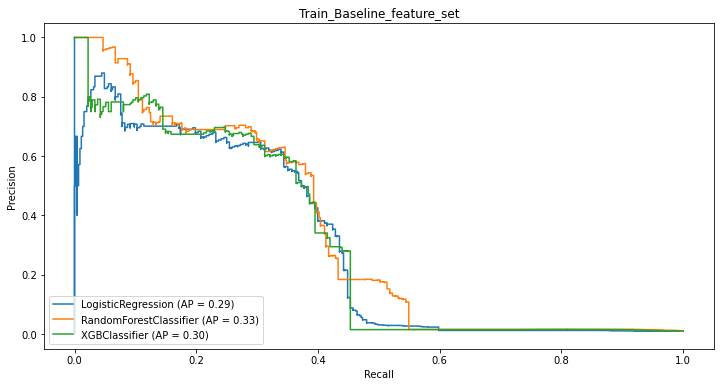

In [15]:
plot_pr_cuves(clf_list, x_test, y_test,title = 'Train_Baseline_feature_set')

### Moving threshold to find Optimal Threshold

In [22]:
rf_probas = clf_rf.predict_proba(x_test)
# keep probabilities for the positive outcome only
rf_probas = rf_probas[:,1]
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=rf_probas)

In [36]:
# manually calculate the F1 score and find the index of argmax of F1 score. 
# use that index to find max threshold.

f_score = (2 * precision * recall) / (precision + recall)

ix = np.argmax(f_score)
threshold = thresholds[ix]
threshold

0.6551995134218912

In [37]:
# Now filtering predictions using this threshold and classification report and confusion matrix

rf_probas = clf_rf.predict_proba(x_test)
y_pred_rf = (rf_probas[:,1] >=threshold).astype('int')

In [40]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     47134
           1       0.57      0.38      0.46       448

    accuracy                           0.99     47582
   macro avg       0.78      0.69      0.73     47582
weighted avg       0.99      0.99      0.99     47582



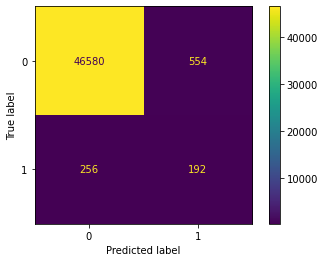

In [44]:
# Default Threshold of 0.5
plot_confusion_matrix(clf_rf, x_test, y_test)

In [48]:
# Using Optimal threshold higher precision, lower recall
# slightly lower recall with lower number of True positives and higher number of false negatives.
# we can give more weightage to recall. Upto the business problem.
confusion_matrix(y_test, y_pred_rf)

array([[47008,   126],
       [  278,   170]])

#### Important Features from Random Forest -  (10 most important features)

In [268]:
## Get feature importance from RF
feat_imp = pd.DataFrame(index=x_train.columns , data = clf_rf.feature_importances_, columns=['Feature_Importance'])
feat_imp.sort_values(by = 'Feature_Importance', axis = 0, ascending=False, inplace = True)
imp_features = feat_imp.index.to_list()[:10]
feat_imp[:10]

,Feature_Importance
feature15,0.298208
days_since_first_week,0.114759
feature37,0.102239
feature12,0.062609
feature19,0.047421
feature18,0.042091
feature47,0.042051
feature16,0.038746
feature21,0.036858
feature22,0.033122


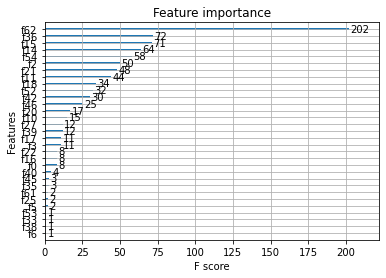

In [269]:
# feature number +1 
plot_importance(xgb_clf)
plt.rcParams['figure.figsize'] = [14, 8]
plt.show()

## B. Recursive Feature Selection 
From Random Forest Classifier and XGBoost Classifer, it appears there are maybe 7-8 important Features. Using RFE to check which are the most useful features. RFE is a greedy technique that uses the .coef_ or .feature_importance attribute of classifiers to reursively build and test models while removing the least useful features at each stage. 

In [17]:
feat_sel = RFE(XGBClassifier(scale_pos_weight = class_weight, max_depth = 6,n_estimators = 100,objective='binary:logistic',
                             learning_rate = .2, eval_metric = 'aucpr', n_jobs = CPU_CORES),
               n_features_to_select=8, step=8, verbose=1)
feat_sel.fit(np.array(x_train), y_train)

Fitting estimator with 62 features.
Fitting estimator with 54 features.
Fitting estimator with 46 features.
Fitting estimator with 38 features.
Fitting estimator with 30 features.
Fitting estimator with 22 features.
Fitting estimator with 14 features.


RFE(estimator=XGBClassifier(base_score=None, booster=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, eval_metric='aucpr',
                            gamma=None, gpu_id=None, importance_type='gain',
                            interaction_constraints=None, learning_rate=0.2,
                            max_delta_step=None, max_depth=6,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=8, num_parallel_tree=None, random_state=None,
                            reg_alpha=None, reg_lambda=None,
                            scale_pos_weight=105.88535031847134, subsample=None,
                            tree_method=None, validate_parameters=None,
                            verbosity=None),
    n_features_to_select=8, step=8, verbose=1)

In [18]:
# Selected features
pd.DataFrame(data = feat_sel.ranking_, index = x_train.columns).sort_values(by = 0, ascending = True).head(10)

,0
feature12,1
feature37,1
feature40,1
feature21,1
feature6,1
feature54,1
feature16,1
feature15,1
feature47,2
feature19,2


In [270]:
rfe_feats = ['feature12', 'feature37', 'feature40','feature21','feature6', 'feature54', 'feature16', 'feature15']
xgb_clf.fit(np.array(x_train[rfe_feats]), y_train, 
             early_stopping_rounds=5, 
             eval_set=[(np.array(x_test[rfe_feats]), y_test)],
             verbose=True)

clf_log.fit(np.array(x_train[rfe_feats]), y_train)
clf_rf.fit(np.array(x_train[rfe_feats]), y_train)

print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train[rfe_feats])))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train[rfe_feats])))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train[rfe_feats])))}')

[0]	validation_0-aucpr:0.30869
Will train until validation_0-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.32278
[2]	validation_0-aucpr:0.32376
[3]	validation_0-aucpr:0.32369
[4]	validation_0-aucpr:0.32502
[5]	validation_0-aucpr:0.32950
[6]	validation_0-aucpr:0.32606
[7]	validation_0-aucpr:0.33757
[8]	validation_0-aucpr:0.34193
[9]	validation_0-aucpr:0.34229
[10]	validation_0-aucpr:0.34545
[11]	validation_0-aucpr:0.34605
[12]	validation_0-aucpr:0.34826
[13]	validation_0-aucpr:0.34803
[14]	validation_0-aucpr:0.34815
[15]	validation_0-aucpr:0.34733
[16]	validation_0-aucpr:0.34967
[17]	validation_0-aucpr:0.34760
[18]	validation_0-aucpr:0.34899
[19]	validation_0-aucpr:0.35228
[20]	validation_0-aucpr:0.35207
[21]	validation_0-aucpr:0.36923
[22]	validation_0-aucpr:0.37033
[23]	validation_0-aucpr:0.37303
[24]	validation_0-aucpr:0.37165
[25]	validation_0-aucpr:0.36753
[26]	validation_0-aucpr:0.36729
[27]	validation_0-aucpr:0.36040
[28]	validation_0-aucpr:0.36171
Stopping. Best it

In [271]:
y_pred_xgb = xgb_clf.predict(np.array(x_test[rfe_feats]))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

XGBClassifier
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     47134
           1       0.12      0.54      0.20       448

    accuracy                           0.96     47582
   macro avg       0.56      0.75      0.59     47582
weighted avg       0.99      0.96      0.97     47582



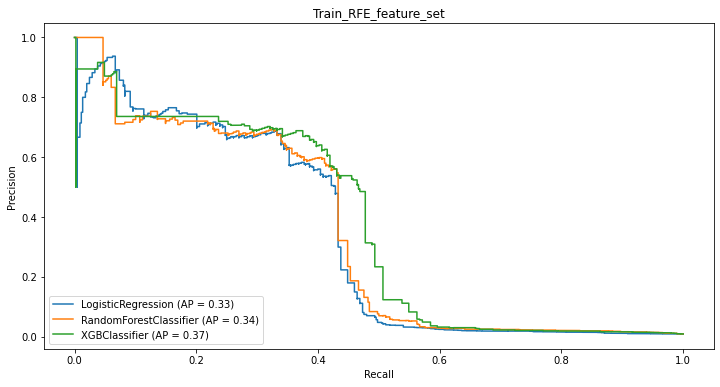

In [272]:
plot_pr_cuves(clf_list, x_test[rfe_feats], y_test,title = 'Train_RFE_feature_set')

## C. Multivariate EDA, Data Interaction and Manual Feature Selection

### Perason's Correlation Between Features 
1. Finding and plotting the features with highest absolute correlations between them, along with the positive labels in yellow. 
2. The most correlated features don't seem to have much discriminating power, most likely adding noise,  can be ignored.

In [20]:
## Getting the highest absolute correlations between features. Get pair of features, find correlations for each pair,
# store in list along with feature names

temp = train.drop(['Label', 'week_start_date'] , axis = 1).copy()
temp_corr = temp.corr()

corr_list = []
pair_feat = []
# Reduced complexity from two nested for loops uisng itertools combinations.
for i, item in enumerate(list(combinations(temp.columns.to_list(),2))):
    pair_feat.append(item)
    
for item in pair_feat:
    corr_list.append([item[0], item[1], np.abs(temp_corr.at[item[0], item[1]])])

corr_array = np.array(corr_list)
corr_array = corr_array[corr_array[:,2].argsort()][::-1]
#corr_array[104:124]

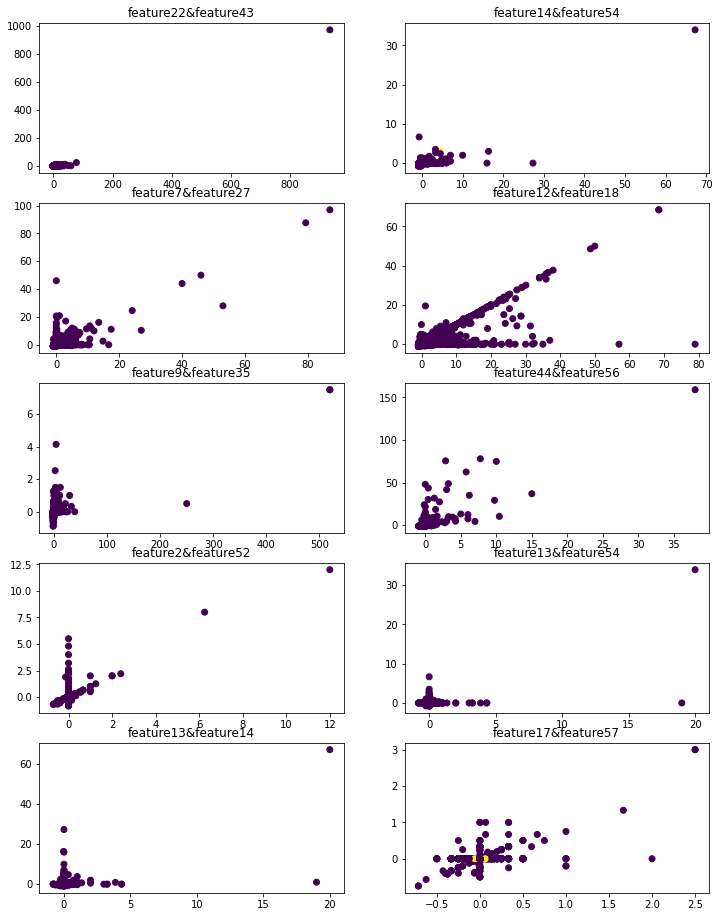

In [21]:
fig = plt.figure()
fig.set_figheight(16)
fig.set_figwidth(12)
for i, item in enumerate(corr_array[104:114]):
    ax = fig.add_subplot(5, 2, i+1)
    plt.scatter(x = train[item[0]].values, y = train[item[1]].values, c = train.Label.values)
    ax.set_title(item[0] + '&' + item[1])

### Pearson's correlation of features with Label 
1. Although the pearson's correlation for the continuous variables and categorical target is not strictly meaningful, in practise it can be useful. <br> 
2. The skew can also affect the correlation, checked later with the majority class undersampled. Tried to model with undersampled data but resulted in worse performance that weighted cost.
3. Features 15, 16, 37 seem to be highly correlated with the label.<br>
<b>Feature Set 1 (3 features with highest Correlation with label)</b>

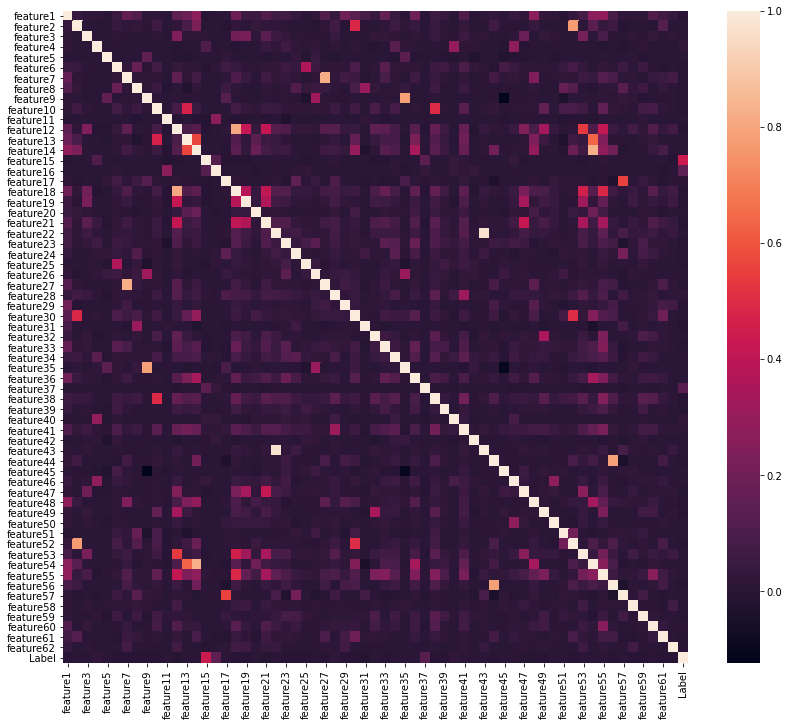

In [22]:
temp = train.copy()
#temp.drop(['Label'], axis =1, inplace = True)
plt.figure(figsize=(14,12))
sns.heatmap(temp.corr(method='pearson'))
plt.show()

### Randomly Undersampling Majority Class and then checking correlation with label
1. This method is not robust as we're throwing away a lot of data. We can see that as values for certain features  in the sample are just 0, shows up as no correlation with any other features below.
2. The features that appear to be correlated with the labels for this sample are the ones selected from the multivariate EDA below. Those assumptions seems to have been correct.
3. Modelled using undersampled data, lower performance than using all data, graph saved in Curves folder, suffixed undersamplped.

In [16]:
temp = train.copy()
# shuffling the train set before 
temp = temp.sample(frac = 1, random_state = 15)
# getting the same number of samples for majority class, 1076
intervene = temp.loc[temp['Label'] == 1]
no_intervene = temp.loc[temp['Label'] == 0].iloc[:1076]
new_df = pd.concat([intervene, no_intervene ])
# shuffling this new df
new_df = new_df.sample(frac=1)
new_df.Label.value_counts()

1    1076
0    1076
Name: Label, dtype: int64

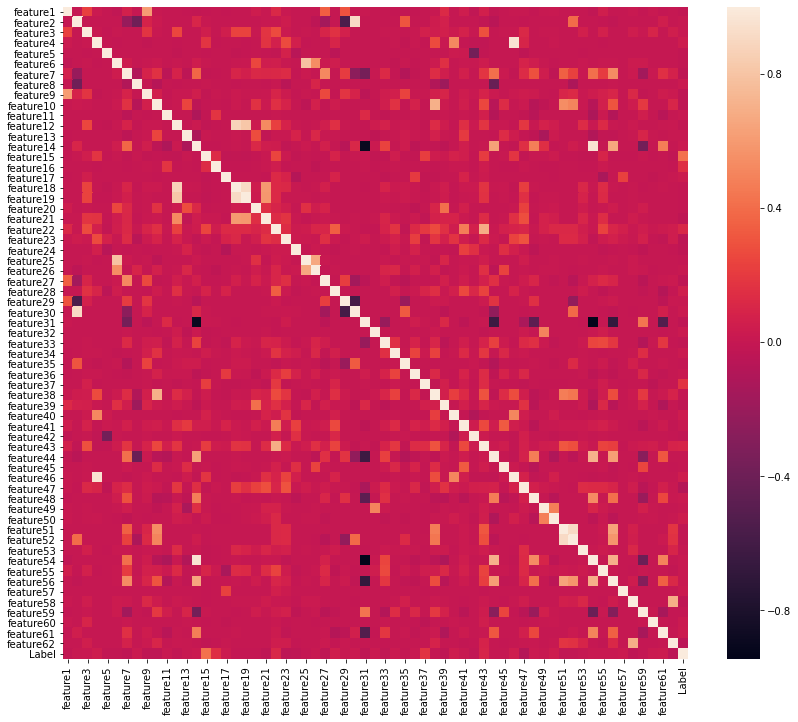

In [17]:
# Now correlations for this balanced subsample. 
plt.figure(figsize=(14,12))
sns.heatmap(new_df.corr(method = 'pearson'))
plt.show()

### Data Interaction of features correlated with label.
1. The yellow points denote the instances where an intervention was required or a label of 1.
2. There is definitely interesting interaction between these features, there is clear distinction between the postive classes in the graphs on the first column.
3. Comparing these plots with the interaction of multiple accounts with features from the livestream, it appears to be that these features cross each other just around the min threshold.
4. These features don't seem to be highly correlated.
2. Interestingly, the useful features are the ones whose interaction have a distinct cross like interaction. The labels turning to 1 somewhat depends on the points being on the outside of the interaction of the points. Can Use this info to find more such interactions(Total 1890 combinations, have to narrow it down).

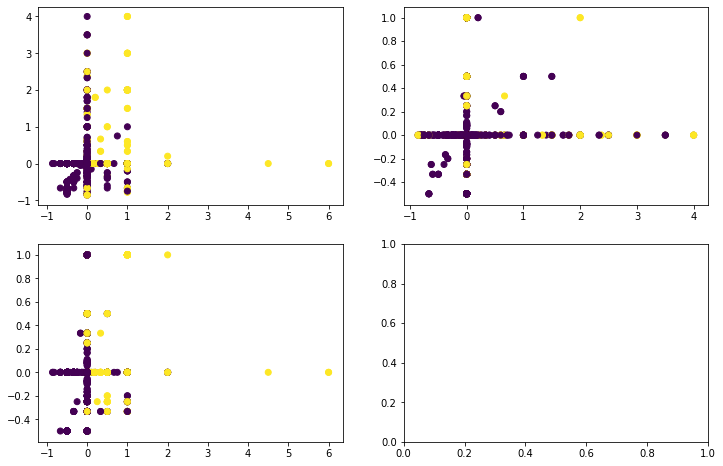

In [27]:
# Correlation of 0.125
fig, ax = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)
ax[0,0].scatter(x = train['feature15'].values, y = train['feature16'].values, c = train.Label.values)
# Correlation of 0.0310
ax[0,1].scatter(x = train['feature16'].values, y = train['feature37'].values, c = train.Label.values)
# Correlation of 0.141
ax[1,0].scatter(x = train['feature15'].values, y = train['feature37'].values, c = train.Label.values)
plt.show()

![](multiple_accounts_single_features.png)

## D. Models using only the features most correlated with the label
1. Similar recall to previous model, much improved precision, the curve is also much more stable across the board.

In [69]:
feature_set_1 = ['feature15', 'feature16', 'feature37']

In [274]:
clf_log.fit(np.array(x_train[feature_set_1]), y_train)
clf_rf.fit(np.array(x_train[feature_set_1]), y_train)
xgb_clf.fit(np.array(x_train[feature_set_1]), y_train, 
             early_stopping_rounds=5, 
             eval_set=[(np.array(x_test[feature_set_1]), y_test)],
             verbose=True)
print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train[feature_set_1])))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train[feature_set_1])))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train[feature_set_1])))}')

[0]	validation_0-aucpr:0.32419
Will train until validation_0-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.31374
[2]	validation_0-aucpr:0.31175
[3]	validation_0-aucpr:0.30854
[4]	validation_0-aucpr:0.31069
[5]	validation_0-aucpr:0.31002
Stopping. Best iteration:
[0]	validation_0-aucpr:0.32419

Logistic Regression - 0.08117225384777567
Random Forest - 0.12000000000000001
XGBoost - 0.5590872045639773


In [275]:
y_pred_log = clf_log.predict(np.array(x_test[feature_set_1]))
y_pred_rf = clf_rf.predict(np.array(x_test[feature_set_1]))
y_pred_xgb = xgb_clf.predict(np.array(x_test[feature_set_1]))
print('Logistic Regression\n', classification_report(y_test, y_pred_log))
print('RandomForestClassifier\n', classification_report(y_test, y_pred_rf))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

Logistic Regression
               precision    recall  f1-score   support

           0       0.99      0.87      0.93     47134
           1       0.04      0.53      0.07       448

    accuracy                           0.87     47582
   macro avg       0.52      0.70      0.50     47582
weighted avg       0.99      0.87      0.92     47582

RandomForestClassifier
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     47134
           1       0.05      0.54      0.10       448

    accuracy                           0.91     47582
   macro avg       0.52      0.73      0.53     47582
weighted avg       0.99      0.91      0.94     47582

XGBClassifier
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     47134
           1       0.42      0.48      0.45       448

    accuracy                           0.99     47582
   macro avg       0.71      0.74      0.72     47582
weighted avg  

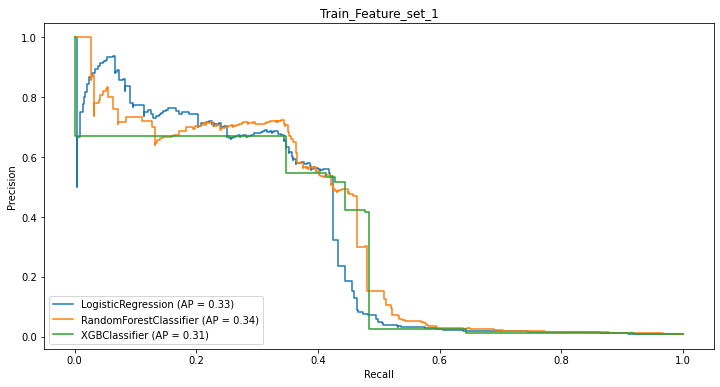

In [276]:
plot_pr_cuves(clf_list, x_test[feature_set_1], y_test,title = 'Train_Feature_set_1')

### Plotting Important features from baseline Random Forest 
1. Interactions of other features shows similar behaviour to the features selected so far, this interaction of the data is seems important.
2. Creating Feature set 2 by combining a few promising features from these interactions and featureset1. 
3. <b>Featureset 2 (7 features). </b> Modelling.
4. Recall increased slightly.

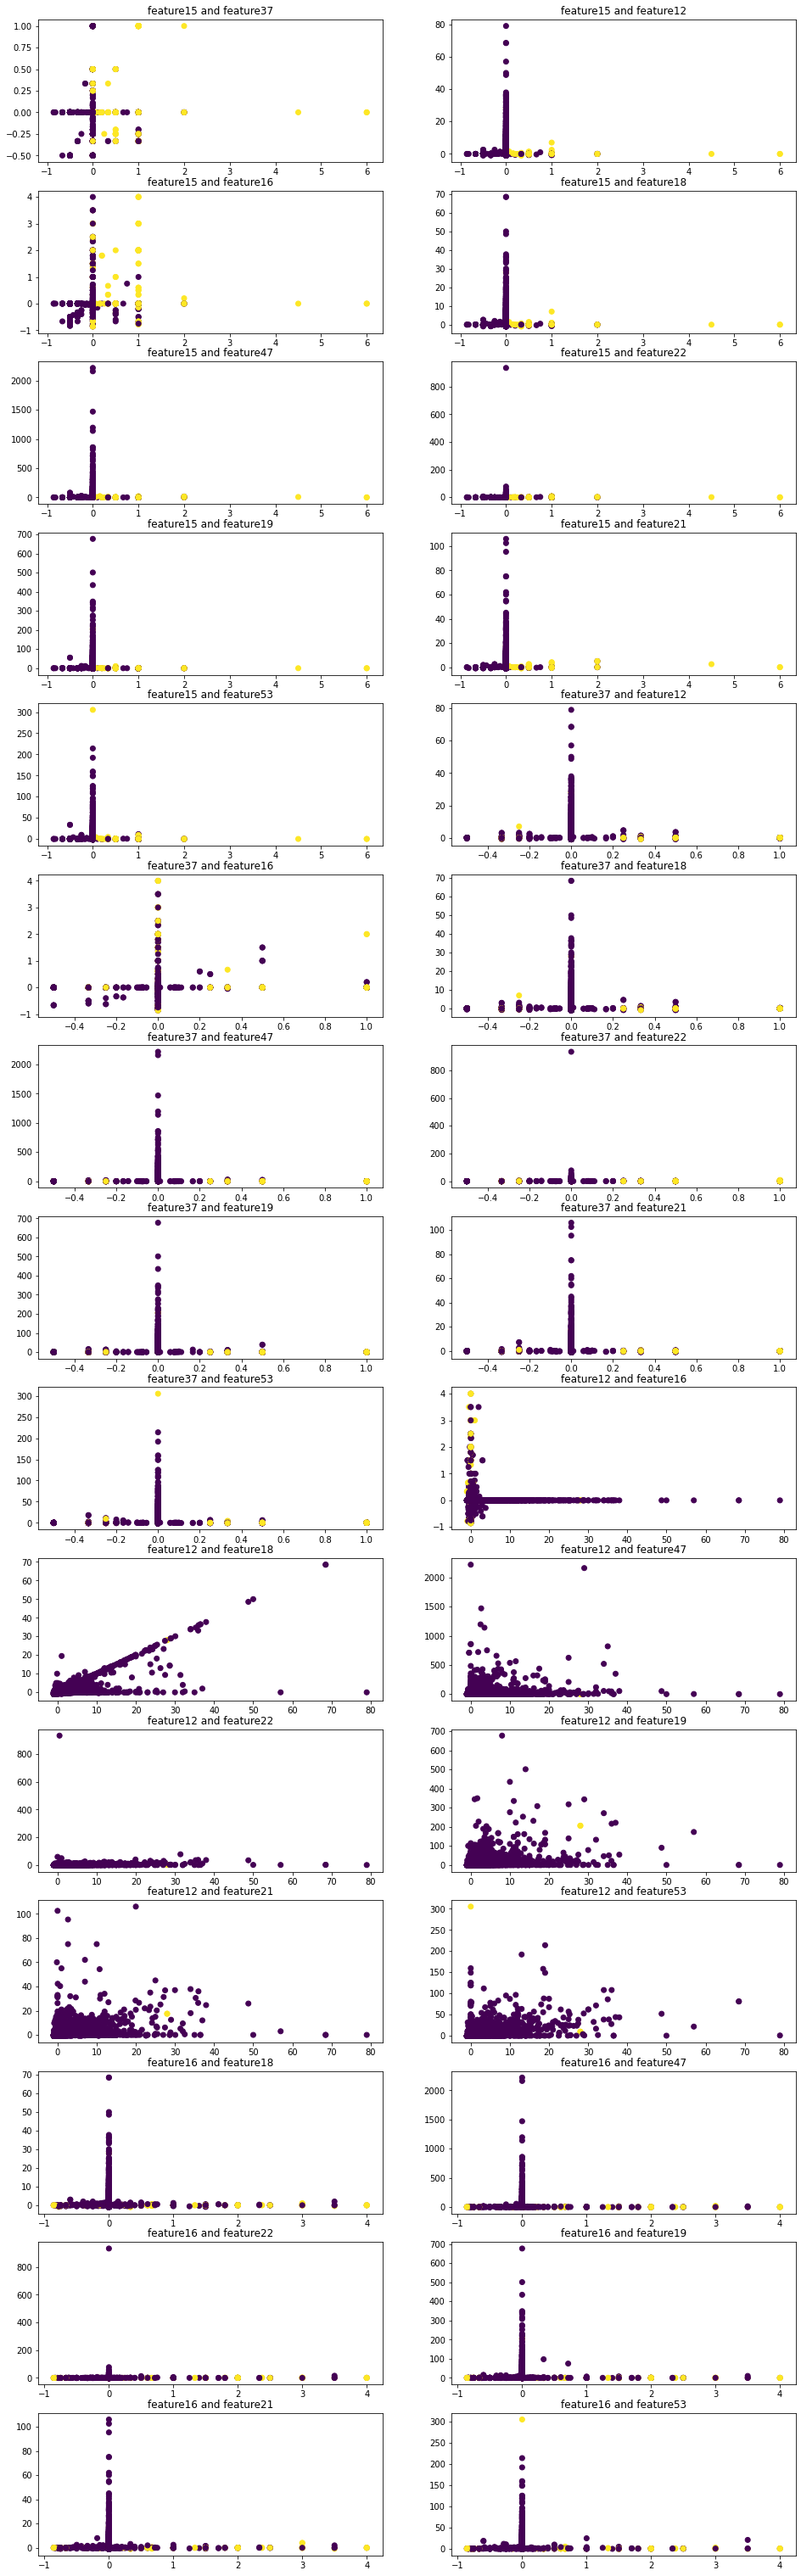

In [26]:
combinations_imp = list(combinations(imp_features, 2))
fig = plt.figure(figsize=(16, 55))
for i, item in enumerate(combinations_imp[:30]):
    ax = fig.add_subplot(15, 2, i+1)
    ax.scatter(x = train[item[0]].values, y = train[item[1]].values, c = train.Label.values)
    ax.title.set_text(f'{item[0]} and {item[1]}')
    
plt.show()

In [277]:
feature_set_2 = ['feature15', 'feature16', 'feature37','feature55',
                 'feature12', 'feature18', 'feature47']

clf_log.fit(np.array(x_train[feature_set_2]), y_train)
clf_rf.fit(np.array(x_train[feature_set_2]), y_train)
xgb_clf.fit(np.array(x_train[feature_set_2]), y_train, 
             early_stopping_rounds=5, 
             eval_set=[(np.array(x_test[feature_set_2]), y_test)],
             verbose=True)
print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train[feature_set_2])))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train[feature_set_2])))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train[feature_set_2])))}')

[0]	validation_0-aucpr:0.31677
Will train until validation_0-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.32567
[2]	validation_0-aucpr:0.32629
[3]	validation_0-aucpr:0.33119
[4]	validation_0-aucpr:0.33147
[5]	validation_0-aucpr:0.33626
[6]	validation_0-aucpr:0.33738
[7]	validation_0-aucpr:0.35323
[8]	validation_0-aucpr:0.35342
[9]	validation_0-aucpr:0.34973
[10]	validation_0-aucpr:0.35111
[11]	validation_0-aucpr:0.35799
[12]	validation_0-aucpr:0.35942
[13]	validation_0-aucpr:0.36216
[14]	validation_0-aucpr:0.36448
[15]	validation_0-aucpr:0.36468
[16]	validation_0-aucpr:0.36563
[17]	validation_0-aucpr:0.36793
[18]	validation_0-aucpr:0.36857
[19]	validation_0-aucpr:0.36918
[20]	validation_0-aucpr:0.36423
[21]	validation_0-aucpr:0.38399
[22]	validation_0-aucpr:0.38188
[23]	validation_0-aucpr:0.39117
[24]	validation_0-aucpr:0.39216
[25]	validation_0-aucpr:0.38817
[26]	validation_0-aucpr:0.38959
[27]	validation_0-aucpr:0.39425
[28]	validation_0-aucpr:0.37861
[29]	validation_0

In [278]:
y_pred_log = clf_log.predict(np.array(x_test[feature_set_2]))
y_pred_rf = clf_rf.predict(np.array(x_test[feature_set_2]))
y_pred_xgb = xgb_clf.predict(np.array(x_test[feature_set_2]))
print('Logistic Regression\n', classification_report(y_test, y_pred_log))
print('RandomForestClassifier\n', classification_report(y_test, y_pred_rf))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

Logistic Regression
               precision    recall  f1-score   support

           0       0.99      0.87      0.93     47134
           1       0.04      0.53      0.07       448

    accuracy                           0.87     47582
   macro avg       0.52      0.70      0.50     47582
weighted avg       0.99      0.87      0.92     47582

RandomForestClassifier
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     47134
           1       0.35      0.46      0.40       448

    accuracy                           0.99     47582
   macro avg       0.67      0.73      0.70     47582
weighted avg       0.99      0.99      0.99     47582

XGBClassifier
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     47134
           1       0.12      0.58      0.20       448

    accuracy                           0.96     47582
   macro avg       0.56      0.77      0.59     47582
weighted avg  

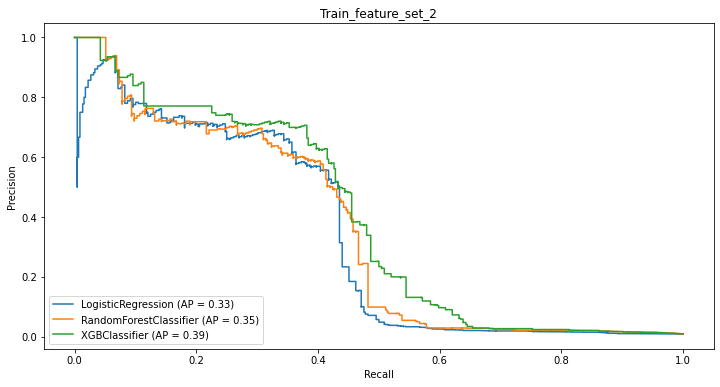

In [279]:
plot_pr_cuves(clf_list, x_test[feature_set_2], y_test,title = 'Train_feature_set_2')

### C. Features with non-zero value and the largest counts of corresponding positive examples.
1. These features could have good discriminating power.
3. Featureset_3 (6 of the features with the largest count of positive examples), modelling.
3. Worse performance compared to featureset 2, the interaction of these features shows that they're going along similar lines, without the cross interaction seen before. Just goes about near the threshold ?
4. Trying to model by combining the two feature sets.

In [46]:
for item in train.columns:
    try:
        print(item, train.loc[train[item]!= 0].Label.value_counts()[1])
    except KeyError:
        pass

week_start_date 1076
feature1 18
feature3 215
feature4 9
feature6 2
feature7 8
feature9 8
feature10 8
feature11 36
feature12 83
feature14 4
feature15 406
feature16 105
feature17 10
feature18 75
feature19 66
feature21 70
feature22 299
feature23 40
feature24 5
feature26 5
feature27 4
feature28 47
feature31 2
feature32 9
feature33 5
feature34 23
feature36 17
feature37 209
feature38 13
feature39 10
feature40 10
feature41 61
feature43 262
feature44 4
feature45 1
feature46 15
feature47 99
feature48 6
feature49 7
feature50 8
feature53 129
feature54 4
feature55 273
feature56 4
feature57 1
feature58 12
feature59 2
feature60 10
feature61 2
feature62 24
Label 1076


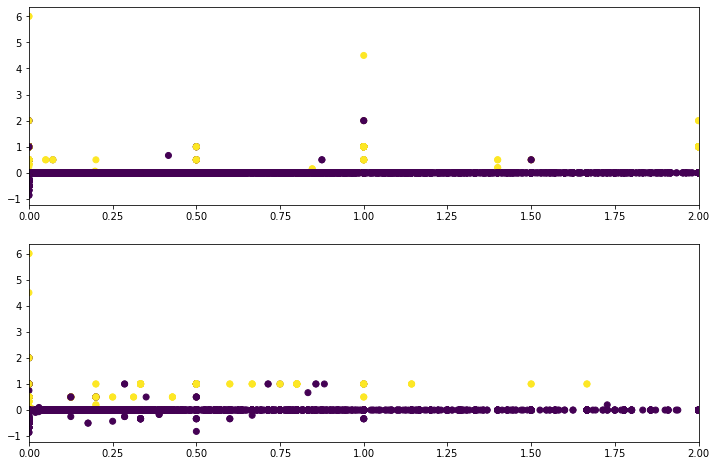

In [74]:
# try checking with 43, 3, 37 
fig, ax = plt.subplots(2, 1)
fig.set_figheight(8)
fig.set_figwidth(12)
ax[0].set_xlim(0,2)
ax[0].scatter(x = train['feature22'].values, y = train['feature15'].values, c = train.Label.values)
ax[1].set_xlim(0,2)
ax[1].scatter(x = train['feature55'].values, y = train['feature15'].values, c = train.Label.values)
plt.show()

In [280]:
feature_set_3 = ['feature15', 'feature22', 'feature55', 'feature43', 'feature3', 'feature37']
clf_log.fit(np.array(x_train[feature_set_3]), y_train)
clf_rf.fit(np.array(x_train[feature_set_3]), y_train)
xgb_clf.fit(np.array(x_train[feature_set_3]), y_train, 
             early_stopping_rounds=5, 
             eval_set=[(np.array(x_test[feature_set_3]), y_test)],
             verbose=True)
print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train[feature_set_3])))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train[feature_set_3])))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train[feature_set_3])))}')

[0]	validation_0-aucpr:0.30758
Will train until validation_0-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.31021
[2]	validation_0-aucpr:0.31203
[3]	validation_0-aucpr:0.31205
[4]	validation_0-aucpr:0.31046
[5]	validation_0-aucpr:0.31676
[6]	validation_0-aucpr:0.31783
[7]	validation_0-aucpr:0.31957
[8]	validation_0-aucpr:0.32115
[9]	validation_0-aucpr:0.32211
[10]	validation_0-aucpr:0.32399
[11]	validation_0-aucpr:0.32450
[12]	validation_0-aucpr:0.32962
[13]	validation_0-aucpr:0.32342
[14]	validation_0-aucpr:0.32306
[15]	validation_0-aucpr:0.33032
[16]	validation_0-aucpr:0.33071
[17]	validation_0-aucpr:0.33144
[18]	validation_0-aucpr:0.33086
[19]	validation_0-aucpr:0.33081
[20]	validation_0-aucpr:0.33689
[21]	validation_0-aucpr:0.33347
[22]	validation_0-aucpr:0.33482
[23]	validation_0-aucpr:0.34369
[24]	validation_0-aucpr:0.35168
[25]	validation_0-aucpr:0.34171
[26]	validation_0-aucpr:0.33867
[27]	validation_0-aucpr:0.33739
[28]	validation_0-aucpr:0.33814
[29]	validation_0

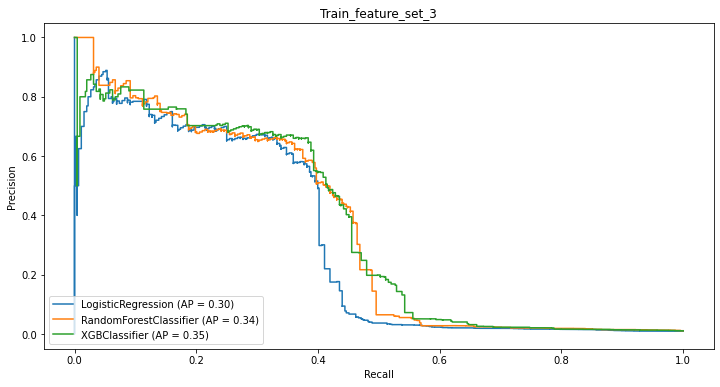

In [281]:
plot_pr_cuves(clf_list, x_test[feature_set_3], y_test,title = 'Train_feature_set_3')

## E. Combining Features Selected till now
1. Featureset 4, 13 selected features.
2. Also Adding a voting classifier ensemble classifier.
3. Similar performance to feature_set_2, slighlty higher precision in upper range of recall.

In [31]:
feature_set_4  = ['feature15','feature37','feature55','feature47','feature18','feature12',
                 'feature19','feature21','feature43','feature16','feature53','feature3','feature22']

In [283]:
vote_clf = VotingClassifier([('log_reg', clf_log), ('rf_clf', clf_rf), ('xgb_clf', xgb_clf)]
                            , voting='soft', n_jobs=-1)
clf_list = [clf_log, clf_rf, xgb_clf, vote_clf]

clf_log.fit(np.array(x_train[feature_set_4]), y_train)
clf_rf.fit(np.array(x_train[feature_set_4]), y_train)
xgb_clf.fit(np.array(x_train[feature_set_4]), y_train, 
             early_stopping_rounds=5, 
             eval_set=[(np.array(x_test[feature_set_4]), y_test)],
             verbose=True)
vote_clf.fit(np.array(x_train[feature_set_4]), y_train)
print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train[feature_set_4])))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train[feature_set_4])))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train[feature_set_4])))}')
print(f'VotingClassifier - {f1_score(y_train, vote_clf.predict(np.array(x_train[feature_set_4])))}')

[0]	validation_0-aucpr:0.31839
Will train until validation_0-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.33041
[2]	validation_0-aucpr:0.33054
[3]	validation_0-aucpr:0.33548
[4]	validation_0-aucpr:0.32902
[5]	validation_0-aucpr:0.33376
[6]	validation_0-aucpr:0.33906
[7]	validation_0-aucpr:0.35300
[8]	validation_0-aucpr:0.35984
[9]	validation_0-aucpr:0.36457
[10]	validation_0-aucpr:0.36047
[11]	validation_0-aucpr:0.36379
[12]	validation_0-aucpr:0.36597
[13]	validation_0-aucpr:0.36836
[14]	validation_0-aucpr:0.36729
[15]	validation_0-aucpr:0.36728
[16]	validation_0-aucpr:0.36953
[17]	validation_0-aucpr:0.36682
[18]	validation_0-aucpr:0.36724
[19]	validation_0-aucpr:0.36938
[20]	validation_0-aucpr:0.36689
[21]	validation_0-aucpr:0.38546
[22]	validation_0-aucpr:0.38599
[23]	validation_0-aucpr:0.38903
[24]	validation_0-aucpr:0.39129
[25]	validation_0-aucpr:0.38854
[26]	validation_0-aucpr:0.38524
[27]	validation_0-aucpr:0.38778
[28]	validation_0-aucpr:0.38592
[29]	validation_0

In [284]:
y_pred = clf_log.predict(np.array(x_test[feature_set_4]))
y_pred_rf = clf_rf.predict(np.array(x_test[feature_set_4]))
y_pred_xgb = xgb_clf.predict(np.array(x_test[feature_set_4]))
y_pred_vclf = vote_clf.predict(np.array(x_test[feature_set_4]))
print(f1_score(y_test, y_pred))
print(f1_score(y_test, y_pred_rf))
print(f1_score(y_test, y_pred_xgb))
print(f1_score(y_test, y_pred_vclf))

0.06931407942238267
0.38345864661654133
0.3
0.14617486338797814


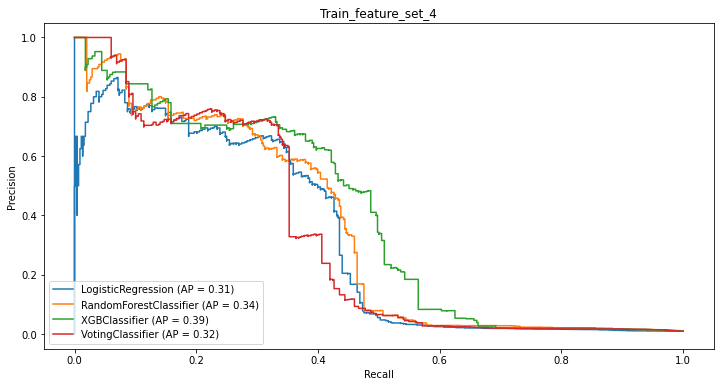

In [286]:
plot_pr_cuves(clf_list, x_test[feature_set_4], y_test,title = 'Train_feature_set_4')

## F. Final Precision-Recall Curves on provided test set Using Naive Approach
1. Training the models on entire training data.
2. Predicting for test data, only using labels for the evaluation.
3. XGBoost with all the features still appears to slighlty outperform the models when trained with featureset4, still that's a reduction of the used features from 62 to 13. Clearly these features are important for the classification.
4. Hyperparameter optimization next, other techniques, feature selection done for the most part.

In [12]:
# Change the featureset before and fit on new featureset before plotting curve.
featureset = baseline_features

In [13]:
x_train = train[featureset]
y_train = train['Label']
x_test = test[featureset]
y_test = test['Label']

In [18]:
clf_log.fit(np.array(x_train[featureset]), y_train)
clf_rf.fit(np.array(x_train[featureset]), y_train)
xgb_clf.fit(np.array(x_train[featureset]), y_train)
# Set according to featureset and early stopping, letting model overfit slightly
xgb_clf.n_estimators = 300
xgb_clf.learning_rate = 0.5

vote_clf.fit(np.array(x_train[featureset]), y_train)

clf_list = [clf_log, clf_rf, xgb_clf, vote_clf]
#clf_list = [clf_log, xgb_clf]


print(f'Logistic Regression - {f1_score(y_train, clf_log.predict(np.array(x_train[featureset])))}')
print(f'Random Forest - {f1_score(y_train, clf_rf.predict(np.array(x_train[featureset])))}')
print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train[featureset])))}')
print(f'VotingClassifier - {f1_score(y_train, vote_clf.predict(np.array(x_train[featureset])))}')

Logistic Regression - 0.4624175824175824
Random Forest - 0.5201096892138939
XGBoost - 0.4906411788132218
VotingClassifier - 0.5414414414414415


In [20]:
y_pred = clf_log.predict(np.array(x_test[featureset]))
y_pred_rf = clf_rf.predict(np.array(x_test[featureset]))
y_pred_xgb = xgb_clf.predict(np.array(x_test[featureset]))
y_pred_vclf = vote_clf.predict(np.array(x_test[featureset]))
print(f1_score(y_test, y_pred))
print(f1_score(y_test, y_pred_rf))
print(f1_score(y_test, y_pred_xgb))
print(f1_score(y_test, y_pred_vclf))

0.4382207578253706
0.5093378607809848
0.46020260492040516
0.5297113752122241


In [74]:
# Before Plotting please, make sure correct featureset selected.

In [ ]:
# Randomly Undersampled data and baseline features 

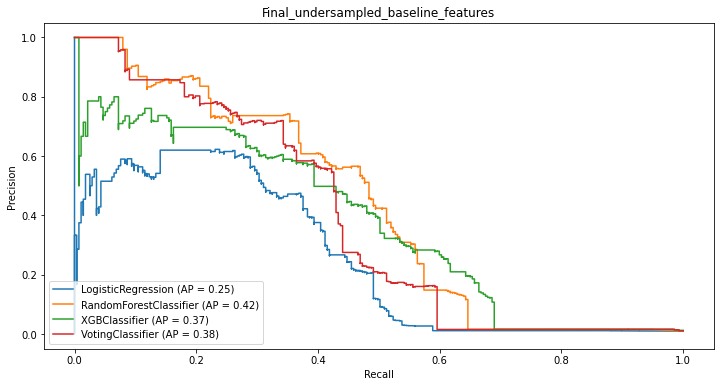

In [43]:
plot_pr_cuves(clf_list, x_test[baseline_features], y_test,title = 'Final_undersampled_baseline_features')

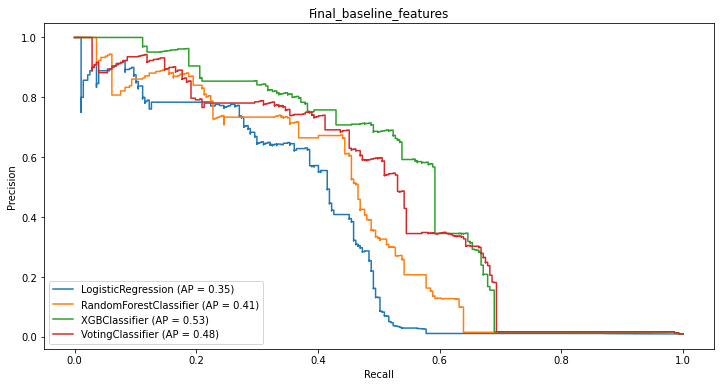

In [86]:
# Baseline features with class ratio - balanced
plot_pr_cuves(clf_list, x_test[baseline_features], y_test,title = 'Final_baseline_features')

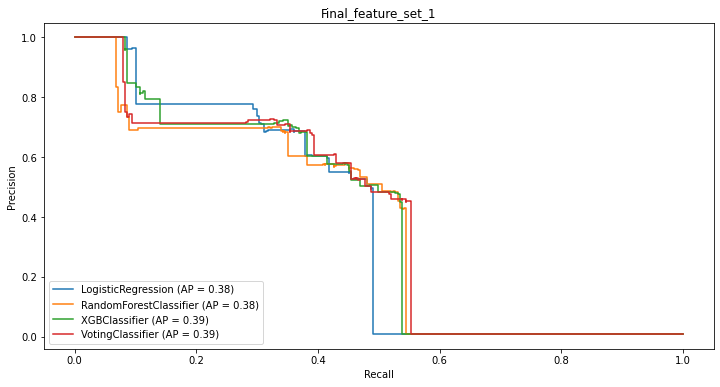

In [92]:
plot_pr_cuves(clf_list, x_test[feature_set_1], y_test,title = 'Final_feature_set_1')

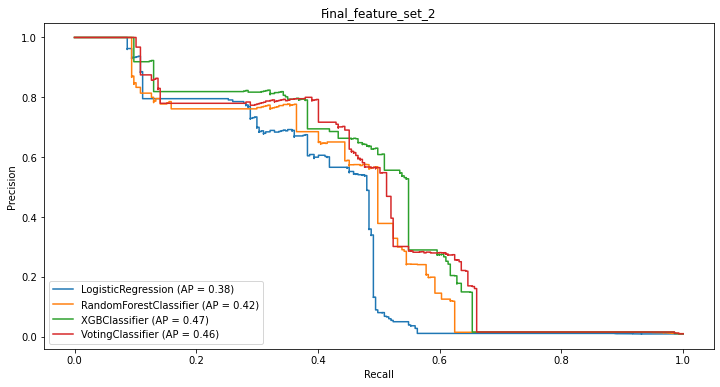

In [98]:
plot_pr_cuves(clf_list, x_test[feature_set_2], y_test,title = 'Final_feature_set_2')

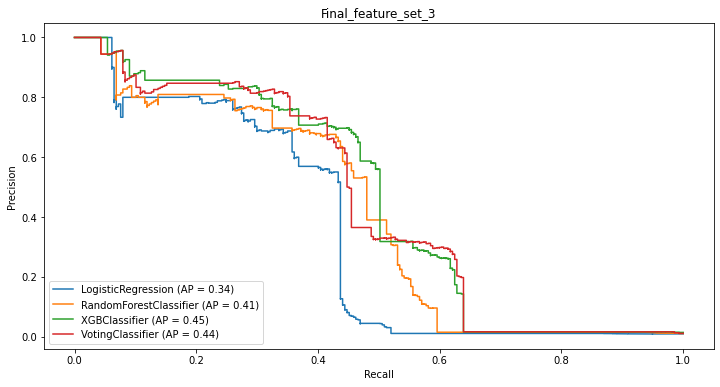

In [103]:
plot_pr_cuves(clf_list, x_test[feature_set_3], y_test,title = 'Final_feature_set_3')

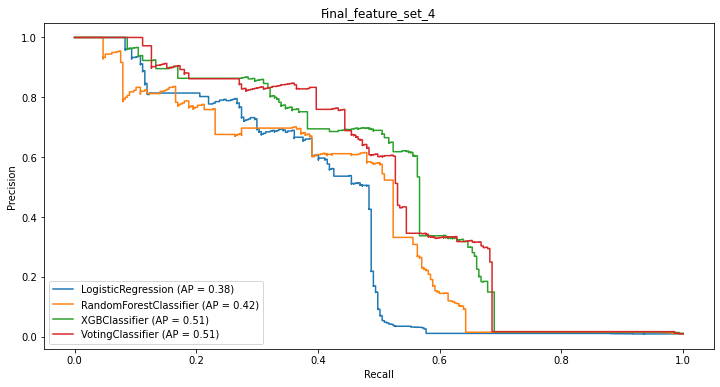

In [108]:
plot_pr_cuves(clf_list, x_test[feature_set_4], y_test,title = 'Final_feature_set_4')

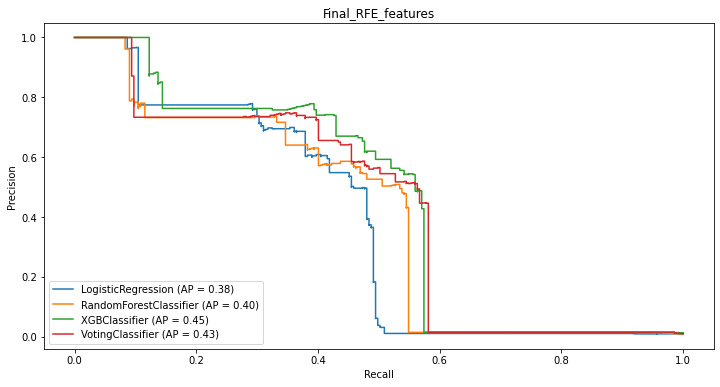

In [21]:
plot_pr_cuves(clf_list, x_test[rfe_feats], y_test,title = 'Final_RFE_features')

### Simple ANN with 4 FC layers
Worse performance than tree based methods, loss saturated at a point. Fairly deep network for simple structured data. Overfits very easily after just 3 epochs.

In [32]:
# standardised data to get 0 mean, 1 std
scale = StandardScaler()

featureset = feature_set_4

x_train = train[featureset]
y_train = train['Label']

# One-hot encoded labels
dummy_labels = np_utils.to_categorical(y_train)

x_test = test[featureset]
y_test = test['Label']

x_train_scale = scale.fit_transform(x_train)
x_test_scale = scale.fit_transform(x_test)
class_weight = y_train.value_counts()[0]/y_train.value_counts()[1]

In [110]:
def base_model():
    model = Sequential()
    model.add(Dense(27, input_shape=(len(featureset),)))
    # Dropout regularization to prevent overfitting
    model.add(Dropout(rate = 0.4))
    model.add(Dense(27, activation = 'relu'))
    model.add(Dropout(rate = 0.4))
    model.add(Dense(27,  activation = 'relu'))
    model.add(Dropout(rate = 0.4))
    model.add(Dense(2, activation = 'sigmoid'))

# Learning parameters

    model.compile(optimizer = 'adam',
                 loss='binary_crossentropy',
                 metrics = ['accuracy'])
    
    return model

In [111]:
model_ann = base_model()
model_ann.fit(x_train_scale, dummy_labels, batch_size = 32, epochs = 3, class_weight = {0:1, 1:class_weight})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
114706/114706 [==============================] - 17s 150us/step - loss: 1.1691 - accuracy: 0.9006
Epoch 2/3
114706/114706 [==============================] - 15s 132us/step - loss: 1.0234 - accuracy: 0.9794
Epoch 3/3
114706/114706 [==============================] - 15s 131us/step - loss: 1.0299 - accuracy: 0.9862


In [112]:
y_pred = model_ann.predict_classes(x_test_scale)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     29343
           1       0.36      0.54      0.43       277

    accuracy                           0.99     29620
   macro avg       0.68      0.77      0.71     29620
weighted avg       0.99      0.99      0.99     29620



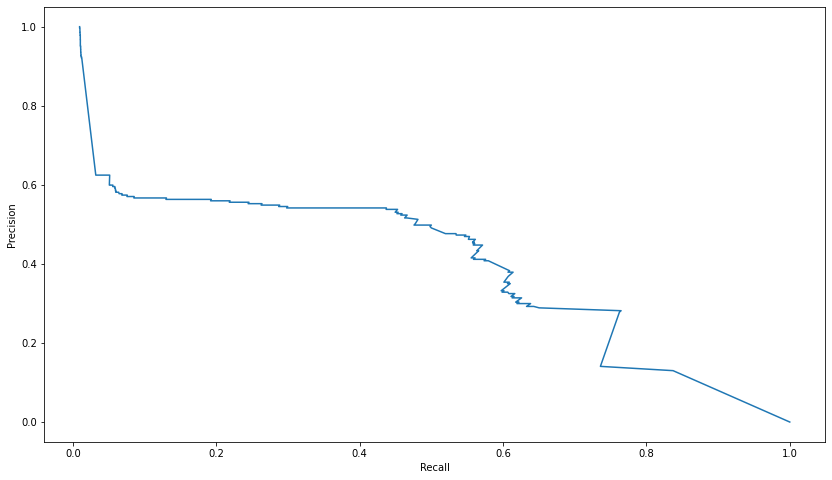

In [113]:
# Plotting precision-Recall on Test Set.
y_pred_proba = model_ann.predict_proba(x_test_scale)
pred_curve = precision_recall_curve(y_test, y_pred_proba[:,1])
plt.plot(pred_curve[0], pred_curve[1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## F. SMOTE - Synthetic Minority Oversampling Technique
Artificially generates minority sample points via a <b> k - nearest neighbour </b> type approach. New instances generated by synthesizing them inbetween features of existing minority samples. Artificially boost the number of minority samples to the around the same as the majority samples. <br>
Worse performance than class_weights = 'balanced'. Better than undersampling, requires tuning of the hypeparameter - ratio: of majority and minority class samples for binary classification. <br>
Important to only uses synthetic points for training, not for validation or test, that'll skew your results and does more harm than good.

In [39]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy = .1)

x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [40]:
y_train.value_counts()

0    113630
1      1076
Name: Label, dtype: int64

In [41]:
y_train_res.value_counts()

0    113630
1     11363
Name: Label, dtype: int64

In [42]:
# Initialising Classifiers with gridsearch optimised parameters, log-reg wont converge with all features
# f-1 score on train dataset. Scores when optimising in excel sheet.

clf_log = LogisticRegression( max_iter = 300)
clf_rf = RandomForestClassifier(n_estimators=150, criterion='gini',
                                max_depth=6)
xgb_clf = XGBClassifier(eta = .3, max_depth = 6,
                        n_estimators = 1000,
                        objective='binary:logistic', learning_rate = .5, eval_metric = 'aucpr')
# saving list of classifiers 
clf_list = [clf_log, clf_rf, xgb_clf]

clf_log.fit(np.array(x_train_res), y_train_res)
clf_rf.fit(np.array(x_train_res), y_train_res)
xgb_clf.fit(np.array(x_train_res), y_train_res, 
#             early_stopping_rounds=5, 
#             eval_set=[(np.array(x_test), y_test)],
             verbose=True)
print(f'Logistic Regression - {f1_score(y_train_res, clf_log.predict(np.array(x_train_res)))}')
print(f'Random Forest - {f1_score(y_train_res, clf_rf.predict(np.array(x_train_res)))}')
print(f'XGBoost - {f1_score(y_train_res, xgb_clf.predict(np.array(x_train_res)))}')

Logistic Regression - 0.5521747246593243
Random Forest - 0.6602810438772583
XGBoost - 0.785579543072731


In [43]:
y_pred_log = clf_log.predict(np.array(x_test))
y_pred_rf = clf_rf.predict(np.array(x_test))
y_pred_xgb = xgb_clf.predict(np.array(x_test))
print('Logistic Regression\n', f1_score(y_test, y_pred_log))
print('RandomForestClassifier\n', f1_score(y_test, y_pred_rf))
print('XGBClassifier\n',f1_score(y_test, y_pred_xgb))

Logistic Regression
 0.49350649350649356
RandomForestClassifier
 0.5214007782101167
XGBClassifier
 0.6142034548944337


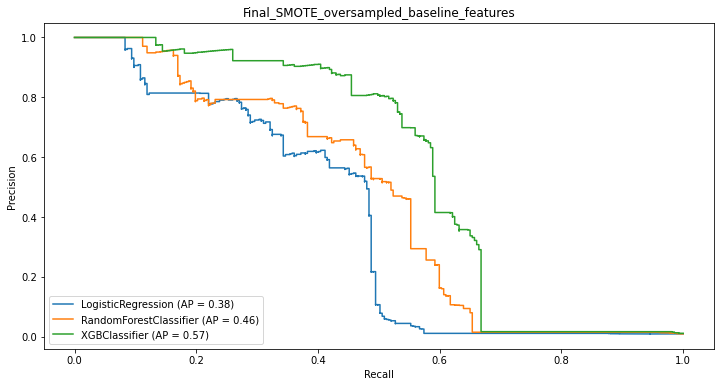

In [58]:
plot_pr_cuves(clf_list, np.array(x_test[baseline_features]), y_test,title = 'Final_SMOTE_oversampled_baseline_features')

In [59]:
from sklearn.metrics import plot_confusion_matrix

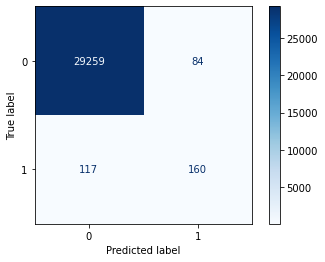

In [61]:
plot_confusion_matrix(xgb_clf, np.array(x_test[baseline_features]), y_test, cmap=plt.cm.Blues)

## G. Isolation Forest
Unsupervised approach where we build multiple trees with the goal of isolating the observations in their leaves. Ideally, each leaf of the tree isolates exactly one observation from your data set. The trees are being split randomly. We assume that if one observation is similar to others in our dataset, it will take more random splits to perfectly isolate this observation, as opposed to isolating an outlier. For an outlier that has some feature values significantly different from the other observations, randomly finding the split isolating it should not be too hard. As we build multiple isolation trees, hence the isolation forest, for each observation we can calculate the average number of splits across all the trees that isolate the observation. The average number of splits is then used as a score, where the less splits the observation needs, the more likely it is to be anomalous.

In [62]:
# It is known that the contamination is 0.009381, not sure if its reasonable to assume that'll always be the case.
# Trying without auto
isforest = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto',
                max_features=1.0, bootstrap=False, n_jobs=-1,
                behaviour='deprecated', random_state=None, verbose=1, warm_start=False)

In [70]:
featureset = feature_set_1
isforest.fit(x_train[featureset])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished


IsolationForest(n_jobs=-1, verbose=1)

In [71]:
res = isforest.predict(x_test[featureset])
res_score = isforest.score_samples(x_test[featureset])
np.unique(res, return_counts=True)

(array([-1,  1]), array([  468, 29152]))

In [72]:
iso_for = pd.DataFrame({'preds' : res,
                          'actual' : y_test,
                          'scores' : -res_score})
iso_for.preds.replace(to_replace=1, value = 0, inplace=True)
iso_for.preds.replace(to_replace=-1, value = 1, inplace=True)
iso_for.preds.value_counts()

0    29152
1      468
Name: preds, dtype: int64

In [73]:
print(classification_report(iso_for.actual, iso_for.preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     29343
           1       0.31      0.53      0.39       277

    accuracy                           0.98     29620
   macro avg       0.65      0.76      0.69     29620
weighted avg       0.99      0.98      0.99     29620



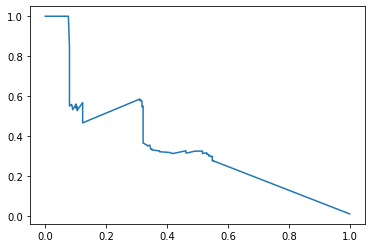

In [74]:
precision, recall, aucpr_score = precision_recall_curve(iso_for.actual, iso_for.scores)
plt.plot(recall, precision)

# 2. Time-Series Approach - Exploring overall Time-Series and by Account ID.
1. The data can be though of as 62 simultaneous time-series, for each feature,for each account. 
2. The time-series are different lengths, makes sense for different customers joining/leaving at different times. Is a problem, looking at a single account first and also how the label acts over all accounts over time.
3. Plot the number of positive labels for the time series, overlay with the number of unique accounts then. See if spike, seasonality etc. (Done)
4. Plot the time series for featuresets from above. (Done)

#### Overall Time-Series : Number of Accounts and Interventions over time
1. There doesn't appear to be any relationship between the growth in the number of accounts, and the number of interventions. One problem is that the cumulative sum includes duplicate accounts. Plotting the change in accounts seems to show a relationship between the two. Statistically significant, strong linear relationship according to pearsons correlation coefficient.
2. Bi-yearly seasonality looks to be present in the number of interventions required.

In [5]:
# Reloading, cannot index by account id, groupby isn't working as expected.
train = pd.read_csv('Train_Set.csv', index_col=0)
test = pd.read_csv('Test_Set.csv', index_col=0)

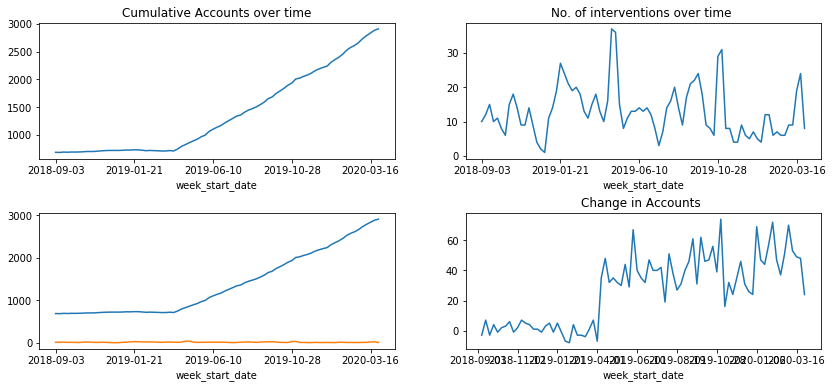

In [246]:
fig, ax = plt.subplots(2, 2, figsize = (14, 6))
plt.subplots_adjust(hspace = 0.4)
train.groupby(['week_start_date'])['account_id'].count().plot(kind = 'line', ax = ax[0,0])
ax[0,0].set_title('Cumulative Accounts over time')
train.groupby(['week_start_date'])['Label'].sum().plot(ax = ax[0,1])
ax[0,1].set_title('No. of interventions over time ')
train.groupby(['week_start_date'])['account_id'].count().plot(kind = 'line', ax = ax[1,0])
train.groupby(['week_start_date'])['Label'].sum().plot(ax = ax[1,0])
change = (temp.groupby(['week_start_date'])['account_id'].count() - 
          temp.groupby(['week_start_date'])['account_id'].count().shift(1))
change.plot(kind = 'line', ax = ax[1,1])
ax[1,1].set_title('Change in Accounts ')
plt.show()

In [224]:
pearsonr(train.groupby(['week_start_date'])['account_id'].count()[1:].values, change.values[1:])

(0.7077372820234344, 1.0515141605376794e-13)

Comparing the trend and any spike in positive labels, and the sum of the values of the features, there doesn't seem to be much correlation except for what was seen in the correlation heatmap.

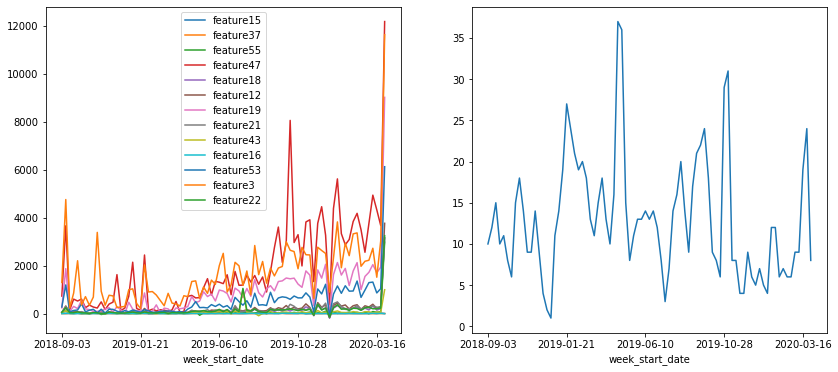

In [263]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))

for item in feature_set_4:
    train.groupby(['week_start_date'])[item].sum().plot(legend = True, ax = ax[0])
    
train.groupby(['week_start_date'])['Label'].sum().plot(ax = ax[1])
plt.show()

#### Account Wise Time-Series

In [232]:
# Accounts with most sample points. 
train['account_id'].value_counts()

104959.0    280
105810.0    278
109056.0    278
100618.0    274
102171.0    272
           ... 
100796.0      1
187594.0      1
101642.0      1
239954.0      1
239955.0      1
Name: account_id, Length: 2690, dtype: int64

Difficult to pin-point any obvious relationship between a features value and the label just by looking at the data. 

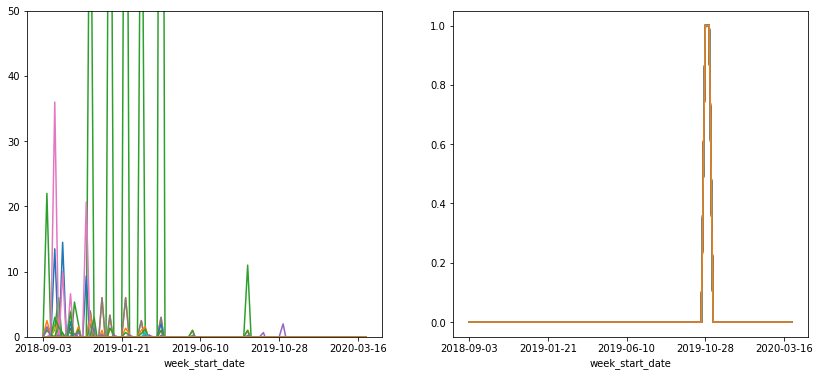

In [284]:
temp = train.loc[train['account_id'] == 104959.0]
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
for item in baseline_features:
    temp.groupby(['week_start_date'])[item].sum().plot(legend = False, ax = ax[0], ylim = (0, 50))
    temp.groupby(['week_start_date'])['Label'].max().plot()

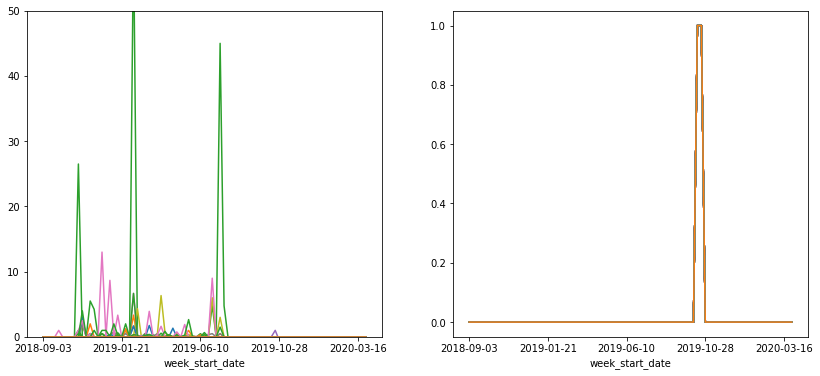

In [288]:
temp = train.loc[train['account_id'] == 105810.0]
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
for item in baseline_features:
    temp.groupby(['week_start_date'])[item].max().plot(legend = False, ax = ax[0], ylim = (0, 50))
    temp.groupby(['week_start_date'])['Label'].max().plot()

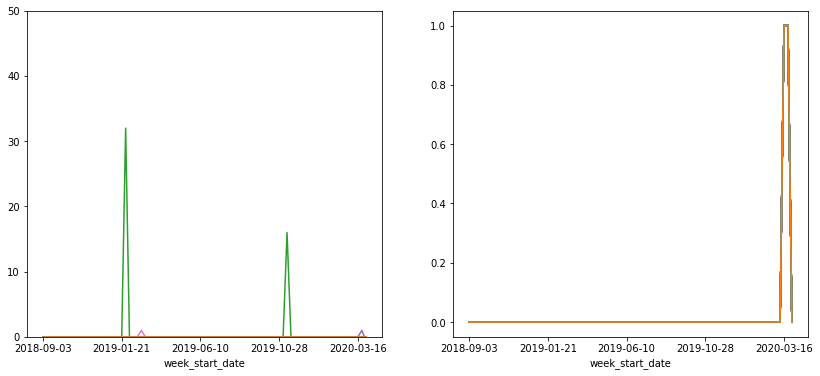

In [289]:
temp = train.loc[train['account_id'] == 109056.0]
fig, ax = plt.subplots(1, 2, figsize = (14, 6))s
for item in baseline_features:
    temp.groupby(['week_start_date'])[item].max().plot(legend = False, ax = ax[0], ylim = (0, 50))
    temp.groupby(['week_start_date'])['Label'].max().plot()

#### Looking at a single account 
Feature interaction with label.

In [199]:
single_feat_acc = acc_1[['week_start_date', 'feature15', 'Label']]
single_feat_acc.describe()

,feature15,Label
count,176.000000,176.000000
mean,0.001894,0.022727
std,0.064214,0.149458
min,-0.333333,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,0.500000,1.000000


In [200]:
single_feat_acc['week_start_date'] = pd.to_datetime(single_feat_acc['week_start_date'])

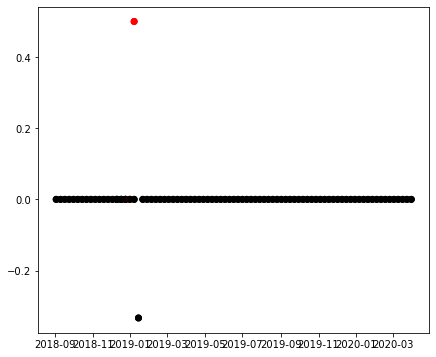

In [201]:
# externally mapping colors 
plt.figure(figsize=(7,6))
c = single_feat_acc.Label.values
colors = np.array(["black", "red"])
plt.scatter(single_feat_acc['week_start_date'], single_feat_acc['feature15'], c=colors[c])
plt.show()

#### Modifying Week start column to Reflect days since first record of account.
1. convert week start date to date time
2. create new column with 0 values
3. filter DF by for each account
3. calculate the days since start for filtered df and replace empty column

In [6]:
train['week_start_date'] = pd.to_datetime(train['week_start_date'])
# same for test set.
test['week_start_date'] = pd.to_datetime(test['week_start_date'])

##### Preparing Time-based features for tree models. 
Days since first record of account.

In [7]:
train['days_since_first_week'] = 0
for account in train.index.unique():
    temp = train.loc[(train.index == account)]
    first_week = temp['week_start_date'].min()
    temp['days_since_first_week'] = temp['week_start_date'].apply(lambda x : x - first_week)
    temp.days_since_first_week = temp.days_since_first_week.dt.days
    train.loc[(train.index == account), 'days_since_first_week'] = temp.days_since_first_week

In [8]:
# Same for external test set for final performance measure later

test['days_since_first_week'] = 0
for account in test.index.unique():
    temp = test.loc[(test.index == account)]
    first_week = temp['week_start_date'].min()
    temp['days_since_first_week'] = temp['week_start_date'].apply(lambda x : x - first_week)
    temp.days_since_first_week = temp.days_since_first_week.dt.days
    test.loc[(test.index == account), 'days_since_first_week'] = temp.days_since_first_week

In [9]:
x_train, x_test, y_train, y_test = train_test_split_acc(train, test_size=0.38)

Split of Labels in train set 
0    0.990644
1    0.009356
Name: Label, dtype: float64
Number of Accounts in Train 1666 

Split of Labels in test set 
0    0.990585
1    0.009415
Name: Label, dtype: float64
Number of Accounts in Train 1024



In [10]:
# Calculating Class Weights.
class_weight = y_train.value_counts()[0]/y_train.value_counts()[1]

In [11]:
# Dropping time-series week start markers. 
x_train.drop(['week_start_date'], axis = 1, inplace=True)
x_test.drop(['week_start_date'], axis = 1, inplace=True)

In [12]:
xgb_clf = XGBClassifier(scale_pos_weight = class_weight, max_depth = 6,
                        n_estimators = 1000,
                        objective='binary:logistic', learning_rate = .2, eval_metric = 'aucpr')

xgb_clf.fit(np.array(x_train), y_train, 
             early_stopping_rounds=5, 
             eval_set=[(np.array(x_test), y_test)],
             verbose=True)

print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train)))}')

[0]	validation_0-aucpr:0.30257
Will train until validation_0-aucpr hasn't improved in 5 rounds.
[1]	validation_0-aucpr:0.31539
[2]	validation_0-aucpr:0.31517
[3]	validation_0-aucpr:0.30679
[4]	validation_0-aucpr:0.30991
[5]	validation_0-aucpr:0.32140
[6]	validation_0-aucpr:0.32697
[7]	validation_0-aucpr:0.33748
[8]	validation_0-aucpr:0.34053
[9]	validation_0-aucpr:0.34768
[10]	validation_0-aucpr:0.34560
[11]	validation_0-aucpr:0.35314
[12]	validation_0-aucpr:0.35556
[13]	validation_0-aucpr:0.35737
[14]	validation_0-aucpr:0.36060
[15]	validation_0-aucpr:0.36121
[16]	validation_0-aucpr:0.36191
[17]	validation_0-aucpr:0.35933
[18]	validation_0-aucpr:0.36114
[19]	validation_0-aucpr:0.36215
[20]	validation_0-aucpr:0.37205
[21]	validation_0-aucpr:0.36897
[22]	validation_0-aucpr:0.36204
[23]	validation_0-aucpr:0.37098
[24]	validation_0-aucpr:0.37375
[25]	validation_0-aucpr:0.37217
[26]	validation_0-aucpr:0.37294
[27]	validation_0-aucpr:0.37512
[28]	validation_0-aucpr:0.37618
[29]	validation_0

In [13]:
y_pred_xgb = xgb_clf.predict(np.array(x_test))
print('XGBClassifier\n',classification_report(y_test, y_pred_xgb))

XGBClassifier
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     47134
           1       0.19      0.53      0.28       448

    accuracy                           0.97     47582
   macro avg       0.59      0.76      0.63     47582
weighted avg       0.99      0.97      0.98     47582



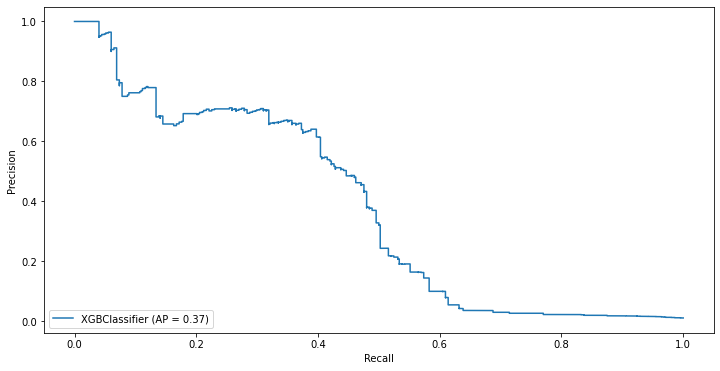

In [14]:
plot_pr_cuves([xgb_clf], np.array(x_test), y_test, '')

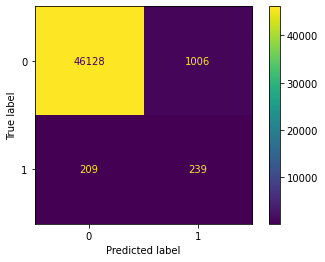

In [15]:
plot_confusion_matrix(xgb_clf, np.array(x_test), y_test)

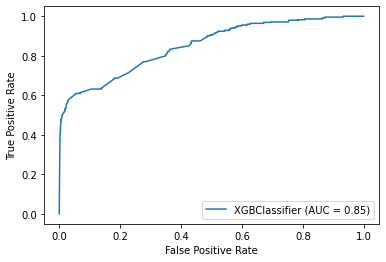

In [18]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(xgb_clf, np.array(x_test), y_test)

#### Optimal Thresholds

In [39]:
xgb_probs = xgb_clf.predict_proba(x_test)

In [42]:
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:,1]

#calculate thresholds 
precision, recall, thresholds = precision_recall_curve(y_true=y_test, probas_pred=xgb_probs)

In [48]:
# manually calculate the f1 score and find max f1 score

f1_score = 2 * (precision *  recall)/ (precision + recall)

In [52]:
# max threshold index

ix = np.argmax(f1_score)
threshold = thresholds[ix]
threshold

0.8847846

In [58]:
# using this threshold to get labels from XGB
y_pred_xgb_opt = (xgb_probs >=threshold).astype('int')

# optimal threshold metrics

print(classification_report(y_test, y_pred_xgb_opt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     47134
           1       0.74      0.64      0.69       448

    accuracy                           0.99     47582
   macro avg       0.87      0.82      0.84     47582
weighted avg       0.99      0.99      0.99     47582



In [61]:
print(confusion_matrix(y_test, y_pred_xgb_opt))

[[47036    98]
 [  163   285]]


### CatBoost

In [19]:
from catboost import CatBoostClassifier, Pool, cv

# preparing pool of features and categorical features(None) for catboost 
train_pool = Pool(x_train, y_train, cat_features=None)

cat_clf = CatBoostClassifier(iterations=1000,
                        learning_rate=.1, loss_function='Logloss', eval_metric='F1', class_weights={0:1, 1:class_weight})

In [20]:
cat_clf.fit(train_pool,
    eval_set=(x_test, y_test),
     #logging_level='Verbose', 
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6321278	test: 0.5760679	best: 0.5760679 (0)	total: 120ms	remaining: 1m 59s
1:	learn: 0.6444268	test: 0.5859264	best: 0.5859264 (1)	total: 176ms	remaining: 1m 28s
2:	learn: 0.6879107	test: 0.6144431	best: 0.6144431 (2)	total: 236ms	remaining: 1m 18s
3:	learn: 0.6967823	test: 0.6130184	best: 0.6144431 (2)	total: 301ms	remaining: 1m 14s
4:	learn: 0.6992117	test: 0.6150824	best: 0.6150824 (4)	total: 383ms	remaining: 1m 16s
5:	learn: 0.7181733	test: 0.6307579	best: 0.6307579 (5)	total: 447ms	remaining: 1m 14s
6:	learn: 0.7211600	test: 0.6355912	best: 0.6355912 (6)	total: 515ms	remaining: 1m 13s
7:	learn: 0.7334211	test: 0.6432526	best: 0.6432526 (7)	total: 578ms	remaining: 1m 11s
8:	learn: 0.7359264	test: 0.6472451	best: 0.6472451 (8)	total: 683ms	remaining: 1m 15s
9:	learn: 0.7350180	test: 0.6434890	best: 0.6472451 (8)	total: 725ms	remaining: 1m 11s
10:	learn: 0.7442226	test: 0.6569361	best: 0.6569361 (10)	total: 756ms	remaining: 1m 8s
11:	learn: 0.7457218	test: 0.6570095	best:

97:	learn: 0.7854705	test: 0.7003795	best: 0.7052443 (81)	total: 5.18s	remaining: 47.7s
98:	learn: 0.7854565	test: 0.7005014	best: 0.7052443 (81)	total: 5.21s	remaining: 47.4s
99:	learn: 0.7865160	test: 0.7021349	best: 0.7052443 (81)	total: 5.25s	remaining: 47.2s
100:	learn: 0.7866920	test: 0.7024448	best: 0.7052443 (81)	total: 5.31s	remaining: 47.3s
101:	learn: 0.7866638	test: 0.7005952	best: 0.7052443 (81)	total: 5.34s	remaining: 47s
102:	learn: 0.7866638	test: 0.7005952	best: 0.7052443 (81)	total: 5.37s	remaining: 46.8s
103:	learn: 0.7865934	test: 0.7060532	best: 0.7060532 (103)	total: 5.41s	remaining: 46.6s
104:	learn: 0.7887974	test: 0.7039414	best: 0.7060532 (103)	total: 5.45s	remaining: 46.4s
105:	learn: 0.7887480	test: 0.7057520	best: 0.7060532 (103)	total: 5.48s	remaining: 46.2s
106:	learn: 0.7887480	test: 0.7057520	best: 0.7060532 (103)	total: 5.51s	remaining: 46s
107:	learn: 0.7887551	test: 0.7057614	best: 0.7060532 (103)	total: 5.54s	remaining: 45.7s
108:	learn: 0.7887762	t

190:	learn: 0.8319768	test: 0.7056333	best: 0.7119555 (161)	total: 8.35s	remaining: 35.3s
191:	learn: 0.8319977	test: 0.7057159	best: 0.7119555 (161)	total: 8.38s	remaining: 35.3s
192:	learn: 0.8320746	test: 0.7075342	best: 0.7119555 (161)	total: 8.41s	remaining: 35.2s
193:	learn: 0.8321165	test: 0.7075066	best: 0.7119555 (161)	total: 8.44s	remaining: 35.1s
194:	learn: 0.8321514	test: 0.7076170	best: 0.7119555 (161)	total: 8.47s	remaining: 35s
195:	learn: 0.8321584	test: 0.7075802	best: 0.7119555 (161)	total: 8.5s	remaining: 34.9s
196:	learn: 0.8322003	test: 0.7075526	best: 0.7119555 (161)	total: 8.53s	remaining: 34.8s
197:	learn: 0.8322492	test: 0.7075986	best: 0.7119555 (161)	total: 8.56s	remaining: 34.7s
198:	learn: 0.8322492	test: 0.7076262	best: 0.7119555 (161)	total: 8.59s	remaining: 34.6s
199:	learn: 0.8322423	test: 0.7076998	best: 0.7119555 (161)	total: 8.62s	remaining: 34.5s
200:	learn: 0.8322702	test: 0.7077090	best: 0.7119555 (161)	total: 8.65s	remaining: 34.4s
201:	learn: 0

283:	learn: 0.8505037	test: 0.6961948	best: 0.7119555 (161)	total: 12.7s	remaining: 32.1s
284:	learn: 0.8505106	test: 0.6961948	best: 0.7119555 (161)	total: 12.8s	remaining: 32.1s
285:	learn: 0.8521871	test: 0.6940926	best: 0.7119555 (161)	total: 12.9s	remaining: 32.1s
286:	learn: 0.8521940	test: 0.6941105	best: 0.7119555 (161)	total: 12.9s	remaining: 32s
287:	learn: 0.8521871	test: 0.6941195	best: 0.7119555 (161)	total: 13s	remaining: 32.1s
288:	learn: 0.8522490	test: 0.6941284	best: 0.7119555 (161)	total: 13.1s	remaining: 32.1s
289:	learn: 0.8522558	test: 0.6941463	best: 0.7119555 (161)	total: 13.1s	remaining: 32.1s
290:	learn: 0.8522833	test: 0.6941911	best: 0.7119555 (161)	total: 13.2s	remaining: 32s
291:	learn: 0.8506349	test: 0.6963119	best: 0.7119555 (161)	total: 13.2s	remaining: 32s
292:	learn: 0.8506349	test: 0.6963029	best: 0.7119555 (161)	total: 13.2s	remaining: 31.9s
293:	learn: 0.8506487	test: 0.6963840	best: 0.7119555 (161)	total: 13.3s	remaining: 31.9s
294:	learn: 0.8506

379:	learn: 0.8569443	test: 0.6886398	best: 0.7119555 (161)	total: 22.9s	remaining: 37.3s
380:	learn: 0.8594831	test: 0.6861001	best: 0.7119555 (161)	total: 22.9s	remaining: 37.3s
381:	learn: 0.8569443	test: 0.6886398	best: 0.7119555 (161)	total: 23s	remaining: 37.2s
382:	learn: 0.8594763	test: 0.6861001	best: 0.7119555 (161)	total: 23s	remaining: 37.1s
383:	learn: 0.8595034	test: 0.6861616	best: 0.7119555 (161)	total: 23.1s	remaining: 37s
384:	learn: 0.8595372	test: 0.6861616	best: 0.7119555 (161)	total: 23.1s	remaining: 36.9s
385:	learn: 0.8595372	test: 0.6861792	best: 0.7119555 (161)	total: 23.2s	remaining: 36.9s
386:	learn: 0.8595304	test: 0.6862055	best: 0.7119555 (161)	total: 23.2s	remaining: 36.8s
387:	learn: 0.8595372	test: 0.6861967	best: 0.7119555 (161)	total: 23.3s	remaining: 36.7s
388:	learn: 0.8595372	test: 0.6861967	best: 0.7119555 (161)	total: 23.3s	remaining: 36.6s
389:	learn: 0.8595574	test: 0.6862055	best: 0.7119555 (161)	total: 23.4s	remaining: 36.6s
390:	learn: 0.85

475:	learn: 0.8614324	test: 0.6769304	best: 0.7119555 (161)	total: 26.7s	remaining: 29.4s
476:	learn: 0.8599159	test: 0.6793373	best: 0.7119555 (161)	total: 26.8s	remaining: 29.3s
477:	learn: 0.8599159	test: 0.6793373	best: 0.7119555 (161)	total: 26.8s	remaining: 29.3s
478:	learn: 0.8599159	test: 0.6793373	best: 0.7119555 (161)	total: 26.8s	remaining: 29.2s
479:	learn: 0.8614593	test: 0.6769304	best: 0.7119555 (161)	total: 26.8s	remaining: 29.1s
480:	learn: 0.8599295	test: 0.6793373	best: 0.7119555 (161)	total: 26.9s	remaining: 29s
481:	learn: 0.8614593	test: 0.6769130	best: 0.7119555 (161)	total: 26.9s	remaining: 28.9s
482:	learn: 0.8614593	test: 0.6769130	best: 0.7119555 (161)	total: 27s	remaining: 28.9s
483:	learn: 0.8599227	test: 0.6793286	best: 0.7119555 (161)	total: 27s	remaining: 28.8s
484:	learn: 0.8599362	test: 0.6793286	best: 0.7119555 (161)	total: 27s	remaining: 28.7s
485:	learn: 0.8599498	test: 0.6793461	best: 0.7119555 (161)	total: 27.1s	remaining: 28.6s
486:	learn: 0.8599

568:	learn: 0.8616271	test: 0.6752597	best: 0.7119555 (161)	total: 29.8s	remaining: 22.6s
569:	learn: 0.8616204	test: 0.6752597	best: 0.7119555 (161)	total: 29.9s	remaining: 22.5s
570:	learn: 0.8616271	test: 0.6752684	best: 0.7119555 (161)	total: 29.9s	remaining: 22.5s
571:	learn: 0.8616271	test: 0.6752684	best: 0.7119555 (161)	total: 29.9s	remaining: 22.4s
572:	learn: 0.8616338	test: 0.6752857	best: 0.7119555 (161)	total: 30s	remaining: 22.3s
573:	learn: 0.8616607	test: 0.6752684	best: 0.7119555 (161)	total: 30s	remaining: 22.3s
574:	learn: 0.8616607	test: 0.6752684	best: 0.7119555 (161)	total: 30s	remaining: 22.2s
575:	learn: 0.8616674	test: 0.6752684	best: 0.7119555 (161)	total: 30.1s	remaining: 22.1s
576:	learn: 0.8616674	test: 0.6752684	best: 0.7119555 (161)	total: 30.1s	remaining: 22.1s
577:	learn: 0.8616808	test: 0.6752684	best: 0.7119555 (161)	total: 30.1s	remaining: 22s
578:	learn: 0.8616808	test: 0.6752684	best: 0.7119555 (161)	total: 30.2s	remaining: 21.9s
579:	learn: 0.8616

662:	learn: 0.8617749	test: 0.6644787	best: 0.7119555 (161)	total: 33s	remaining: 16.8s
663:	learn: 0.8617950	test: 0.6644873	best: 0.7119555 (161)	total: 33s	remaining: 16.7s
664:	learn: 0.8618018	test: 0.6644873	best: 0.7119555 (161)	total: 33.1s	remaining: 16.7s
665:	learn: 0.8618018	test: 0.6644873	best: 0.7119555 (161)	total: 33.1s	remaining: 16.6s
666:	learn: 0.8618018	test: 0.6644873	best: 0.7119555 (161)	total: 33.3s	remaining: 16.6s
667:	learn: 0.8618018	test: 0.6644873	best: 0.7119555 (161)	total: 33.3s	remaining: 16.6s
668:	learn: 0.8618286	test: 0.6645045	best: 0.7119555 (161)	total: 33.3s	remaining: 16.5s
669:	learn: 0.8618286	test: 0.6645045	best: 0.7119555 (161)	total: 33.4s	remaining: 16.4s
670:	learn: 0.8618421	test: 0.6645045	best: 0.7119555 (161)	total: 33.4s	remaining: 16.4s
671:	learn: 0.8618421	test: 0.6645045	best: 0.7119555 (161)	total: 33.4s	remaining: 16.3s
672:	learn: 0.8618421	test: 0.6645045	best: 0.7119555 (161)	total: 33.5s	remaining: 16.3s
673:	learn: 0.

758:	learn: 0.8618824	test: 0.6553675	best: 0.7119555 (161)	total: 37s	remaining: 11.7s
759:	learn: 0.8618824	test: 0.6554017	best: 0.7119555 (161)	total: 37s	remaining: 11.7s
760:	learn: 0.8618824	test: 0.6554188	best: 0.7119555 (161)	total: 37s	remaining: 11.6s
761:	learn: 0.8618824	test: 0.6554188	best: 0.7119555 (161)	total: 37.1s	remaining: 11.6s
762:	learn: 0.8618757	test: 0.6554274	best: 0.7119555 (161)	total: 37.2s	remaining: 11.5s
763:	learn: 0.8618757	test: 0.6554103	best: 0.7119555 (161)	total: 37.2s	remaining: 11.5s
764:	learn: 0.8618757	test: 0.6554103	best: 0.7119555 (161)	total: 37.2s	remaining: 11.4s
765:	learn: 0.8618824	test: 0.6554103	best: 0.7119555 (161)	total: 37.3s	remaining: 11.4s
766:	learn: 0.8618824	test: 0.6554103	best: 0.7119555 (161)	total: 37.3s	remaining: 11.3s
767:	learn: 0.8618891	test: 0.6554103	best: 0.7119555 (161)	total: 37.3s	remaining: 11.3s
768:	learn: 0.8618891	test: 0.6554103	best: 0.7119555 (161)	total: 37.3s	remaining: 11.2s
769:	learn: 0.86

858:	learn: 0.8620034	test: 0.6554959	best: 0.7119555 (161)	total: 40s	remaining: 6.57s
859:	learn: 0.8620034	test: 0.6554959	best: 0.7119555 (161)	total: 40.1s	remaining: 6.52s
860:	learn: 0.8620034	test: 0.6554959	best: 0.7119555 (161)	total: 40.1s	remaining: 6.47s
861:	learn: 0.8620034	test: 0.6554959	best: 0.7119555 (161)	total: 40.1s	remaining: 6.42s
862:	learn: 0.8620034	test: 0.6554959	best: 0.7119555 (161)	total: 40.1s	remaining: 6.37s
863:	learn: 0.8620034	test: 0.6554959	best: 0.7119555 (161)	total: 40.1s	remaining: 6.32s
864:	learn: 0.8620034	test: 0.6554959	best: 0.7119555 (161)	total: 40.2s	remaining: 6.27s
865:	learn: 0.8620034	test: 0.6554959	best: 0.7119555 (161)	total: 40.2s	remaining: 6.22s
866:	learn: 0.8620034	test: 0.6554959	best: 0.7119555 (161)	total: 40.2s	remaining: 6.17s
867:	learn: 0.8620034	test: 0.6554959	best: 0.7119555 (161)	total: 40.3s	remaining: 6.13s
868:	learn: 0.8620034	test: 0.6554959	best: 0.7119555 (161)	total: 40.3s	remaining: 6.08s
869:	learn: 

950:	learn: 0.8620235	test: 0.6554959	best: 0.7119555 (161)	total: 42.5s	remaining: 2.19s
951:	learn: 0.8620235	test: 0.6554959	best: 0.7119555 (161)	total: 42.5s	remaining: 2.14s
952:	learn: 0.8620235	test: 0.6554959	best: 0.7119555 (161)	total: 42.5s	remaining: 2.1s
953:	learn: 0.8620235	test: 0.6554959	best: 0.7119555 (161)	total: 42.6s	remaining: 2.05s
954:	learn: 0.8620235	test: 0.6554959	best: 0.7119555 (161)	total: 42.6s	remaining: 2.01s
955:	learn: 0.8620235	test: 0.6554959	best: 0.7119555 (161)	total: 42.6s	remaining: 1.96s
956:	learn: 0.8620235	test: 0.6554959	best: 0.7119555 (161)	total: 42.6s	remaining: 1.92s
957:	learn: 0.8620235	test: 0.6554959	best: 0.7119555 (161)	total: 42.6s	remaining: 1.87s
958:	learn: 0.8620235	test: 0.6554959	best: 0.7119555 (161)	total: 42.7s	remaining: 1.82s
959:	learn: 0.8620235	test: 0.6554959	best: 0.7119555 (161)	total: 42.7s	remaining: 1.78s
960:	learn: 0.8620235	test: 0.6555044	best: 0.7119555 (161)	total: 42.7s	remaining: 1.73s
961:	learn:

In [21]:
# Catboost seems to be using a different form of f1 averaging than sklearn models. Much higher. 
cat_clf.best_score_

{'learn': {'Logloss': 0.24227274159675485, 'F1': 0.8620302572817196},
 'validation': {'Logloss': 0.4639165721038058, 'F1': 0.7119555277287287}}

In [22]:
y_pred_catb = cat_clf.predict(x_test)
print('CatBoostClassifier\n',classification_report(y_test, y_pred_catb))

CatBoostClassifier
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     47134
           1       0.10      0.58      0.17       448

    accuracy                           0.95     47582
   macro avg       0.55      0.77      0.57     47582
weighted avg       0.99      0.95      0.96     47582



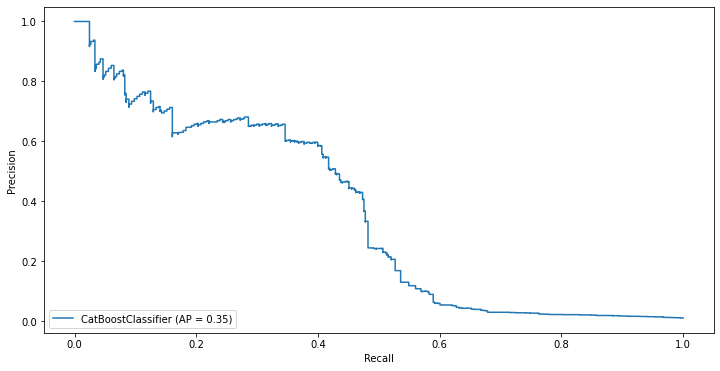

In [23]:
plot_pr_cuves([cat_clf], x_test, y_test, '')

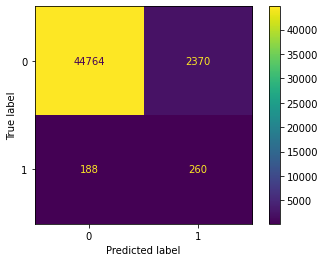

In [24]:
# Slightly better than XGBoost 
plot_confusion_matrix(cat_clf, x_test, y_test)

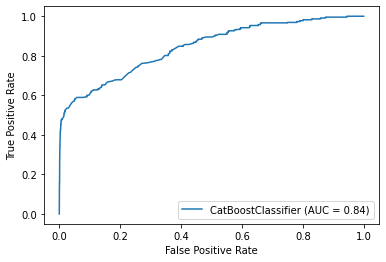

In [25]:
plot_roc_curve(cat_clf, x_test, y_test)

In [64]:
cat_clf_probs = cat_clf.predict_proba(x_test)

# only keeping the positive class 

cat_clf_probs = cat_clf_probs[:,1]

In [66]:
precision, recall, thresholds = precision_recall_curve(y_test, cat_clf_probs)

In [67]:
# manually calculate the F1 score and find the index of argmax of F1 score. 
# use that index to find max threshold.

f_score = (2 * precision * recall) / (precision + recall)

ix = np.argmax(f_score)
threshold = thresholds[ix]
threshold

0.8925628459096298

In [68]:
# using this threshold to get labels from XGB
y_pred_cat_opt = (cat_clf_probs >=threshold).astype('int')

# optimal threshold metrics

print(classification_report(y_test, y_pred_cat_opt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     47134
           1       0.63      0.54      0.58       448

    accuracy                           0.99     47582
   macro avg       0.81      0.77      0.79     47582
weighted avg       0.99      0.99      0.99     47582



In [69]:
print(confusion_matrix(y_test, y_pred_cat_opt))

[[46994   140]
 [  208   240]]


### Final test set Evaluation
Training catBoost for 200 iterations going by train, validation performance.

In [70]:
cat_clf = CatBoostClassifier(iterations=200,
                        learning_rate=.1, loss_function='Logloss', eval_metric='F1',
                             class_weights={0:1, 1:class_weight})

cat_clf.fit(train.drop(['week_start_date', 'Label'], axis =1),train['Label'], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6421557	total: 112ms	remaining: 22.2s
1:	learn: 0.6865995	total: 210ms	remaining: 20.8s
2:	learn: 0.7011042	total: 289ms	remaining: 19s
3:	learn: 0.6972179	total: 377ms	remaining: 18.5s
4:	learn: 0.7040190	total: 473ms	remaining: 18.4s
5:	learn: 0.7064420	total: 567ms	remaining: 18.3s
6:	learn: 0.7110851	total: 659ms	remaining: 18.2s
7:	learn: 0.7089402	total: 745ms	remaining: 17.9s
8:	learn: 0.7135554	total: 841ms	remaining: 17.9s
9:	learn: 0.7082199	total: 935ms	remaining: 17.8s
10:	learn: 0.7217418	total: 1.03s	remaining: 17.6s
11:	learn: 0.7224049	total: 1.11s	remaining: 17.3s
12:	learn: 0.7268052	total: 1.28s	remaining: 18.4s
13:	learn: 0.7294431	total: 1.43s	remaining: 19s
14:	learn: 0.7360839	total: 1.63s	remaining: 20.1s
15:	learn: 0.7369130	total: 1.7s	remaining: 19.5s
16:	learn: 0.7375017	total: 1.75s	remaining: 18.8s
17:	learn: 0.7375496	total: 1.85s	remaining: 18.8s
18:	learn: 0.7390120	total: 1.91s	remaining: 18.2s
19:	learn: 0.7397420	total: 1.95s	remaining: 1

163:	learn: 0.8261158	total: 10.9s	remaining: 2.4s
164:	learn: 0.8260750	total: 11s	remaining: 2.33s
165:	learn: 0.8264051	total: 11s	remaining: 2.26s
166:	learn: 0.8265193	total: 11.1s	remaining: 2.19s
167:	learn: 0.8272463	total: 11.3s	remaining: 2.15s
168:	learn: 0.8273157	total: 11.4s	remaining: 2.09s
169:	learn: 0.8285108	total: 11.5s	remaining: 2.02s
170:	learn: 0.8284945	total: 11.6s	remaining: 1.96s
171:	learn: 0.8285475	total: 11.6s	remaining: 1.89s
172:	learn: 0.8285475	total: 11.7s	remaining: 1.82s
173:	learn: 0.8285761	total: 11.7s	remaining: 1.75s
174:	learn: 0.8366399	total: 11.8s	remaining: 1.68s
175:	learn: 0.8366115	total: 11.8s	remaining: 1.61s
176:	learn: 0.8402991	total: 11.9s	remaining: 1.54s
177:	learn: 0.8416446	total: 11.9s	remaining: 1.47s
178:	learn: 0.8416164	total: 12s	remaining: 1.4s
179:	learn: 0.8373179	total: 12s	remaining: 1.33s
180:	learn: 0.8373179	total: 12.1s	remaining: 1.26s
181:	learn: 0.8373584	total: 12.1s	remaining: 1.2s
182:	learn: 0.8374761	t

In [87]:
xgb_clf = XGBClassifier(scale_pos_weight = class_weight, max_depth = 6,
                        n_estimators = 100,
                        objective='binary:logistic', learning_rate = .2, eval_metric = 'aucpr')

xgb_clf.fit(train.drop(['week_start_date', 'Label'], axis =1),train['Label'])

In [28]:
# Final predictions on Test set using the optimal thresholds from training

catboost_preds = cat_clf.predict(test.drop(['week_start_date', 'Label'], axis =1))

In [29]:
xgb_preds = xgb_clf.predict(test.drop(['week_start_date', 'Label'], axis =1))

In [30]:
print(classification_report(test['Label'], catboost_preds))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     29343
           1       0.10      0.73      0.18       277

    accuracy                           0.94     29620
   macro avg       0.55      0.83      0.57     29620
weighted avg       0.99      0.94      0.96     29620



In [31]:
print(classification_report(test['Label'], xgb_preds))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     29343
           1       0.11      0.73      0.19       277

    accuracy                           0.94     29620
   macro avg       0.55      0.84      0.58     29620
weighted avg       0.99      0.94      0.96     29620



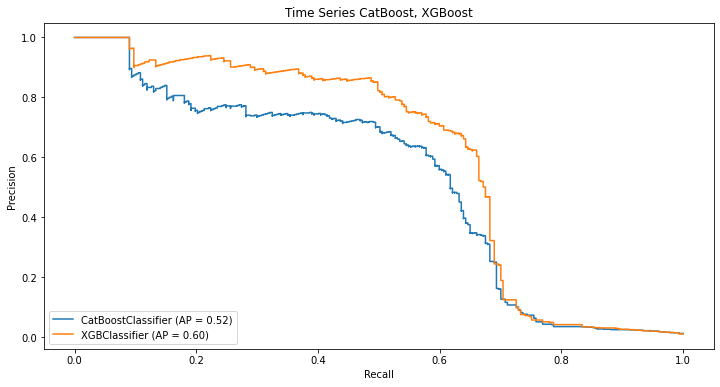

In [32]:
plot_pr_cuves([cat_clf, xgb_clf], test.drop(['week_start_date', 'Label'], axis =1), test['Label'], 'Time Series CatBoost, XGBoost')

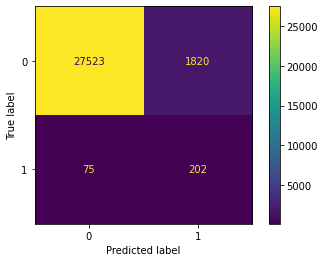

In [33]:
plot_confusion_matrix(cat_clf, test.drop(['week_start_date', 'Label'], axis =1), test['Label'])

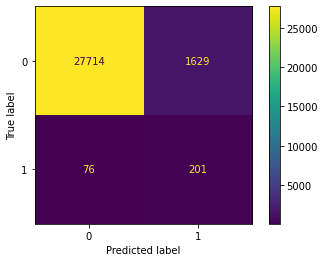

In [34]:
plot_confusion_matrix(xgb_clf, test.drop(['week_start_date', 'Label'], axis =1), test['Label'])

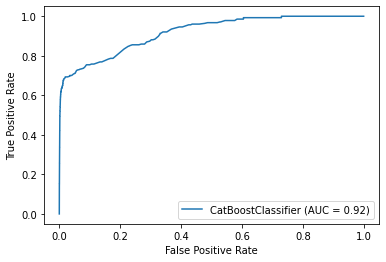

In [35]:
plot_roc_curve(cat_clf, test.drop(['week_start_date', 'Label'], axis =1), test['Label'])

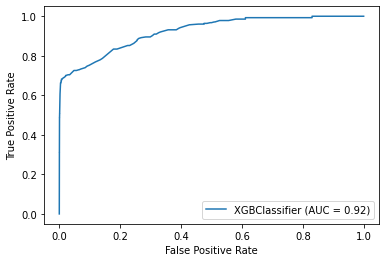

In [36]:
plot_roc_curve(xgb_clf, test.drop(['week_start_date', 'Label'], axis =1), test['Label'])

## Idea : 
Keep only the instances where the label changes and a couple of records either way of them. Performs worse than the approach I've been using upto this point. 
1. Look at feature importance. 
2. When keeping records each entry apart from the true label, some duplicate records - removed (keeping them gives better validation performance but much worse test set AUPR And ROC AUC although recall is slightly higher). 

In [316]:
train.reset_index(inplace=True)

In [317]:
index_true = train.index[train.Label == 1]

In [318]:
new_index = index_true.append(index_true + 1).append(index_true - 1)

In [319]:
# think about removing duplicate index items here 
new_index = new_index.drop_duplicates()

In [320]:
new_train = train.loc[new_index]

In [321]:
new_train = new_train.set_index('account_id')

In [322]:
x_train, x_test, y_train, y_test = train_test_split_acc(new_train)

Split of Labels in train set 
0    0.558389
1    0.441611
Name: Label, dtype: float64
Number of Accounts in Train 201 

Split of Labels in test set 
0    0.569072
1    0.430928
Name: Label, dtype: float64
Number of Accounts in Train 126



In [323]:
#### Sanity check 
overlap_sanity_check(x_train, x_test)

In [324]:
# Dropping time-series week start markers. 
x_train.drop(['week_start_date'], axis = 1, inplace=True)
x_test.drop(['week_start_date'], axis = 1, inplace=True)

In [325]:
xgb_clf = XGBClassifier( max_depth = 6,
                        n_estimators = 1000,
                        objective='binary:logistic', learning_rate = .2, eval_metric = 'aucpr')

xgb_clf.fit(np.array(x_train), y_train, 
             early_stopping_rounds=10, 
             eval_set=[(np.array(x_test), y_test)],
             verbose=True)

print(f'XGBoost - {f1_score(y_train, xgb_clf.predict(np.array(x_train)))}')

[0]	validation_0-aucpr:0.74587
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.75140
[2]	validation_0-aucpr:0.75513
[3]	validation_0-aucpr:0.76184
[4]	validation_0-aucpr:0.76053
[5]	validation_0-aucpr:0.76942
[6]	validation_0-aucpr:0.77765
[7]	validation_0-aucpr:0.77737
[8]	validation_0-aucpr:0.77496
[9]	validation_0-aucpr:0.77715
[10]	validation_0-aucpr:0.78221
[11]	validation_0-aucpr:0.78016
[12]	validation_0-aucpr:0.77797
[13]	validation_0-aucpr:0.77988
[14]	validation_0-aucpr:0.78047
[15]	validation_0-aucpr:0.77849
[16]	validation_0-aucpr:0.78070
[17]	validation_0-aucpr:0.78147
[18]	validation_0-aucpr:0.77748
[19]	validation_0-aucpr:0.78389
[20]	validation_0-aucpr:0.78303
[21]	validation_0-aucpr:0.78166
[22]	validation_0-aucpr:0.77891
[23]	validation_0-aucpr:0.77811
[24]	validation_0-aucpr:0.77776
[25]	validation_0-aucpr:0.77713
[26]	validation_0-aucpr:0.77743
[27]	validation_0-aucpr:0.77901
[28]	validation_0-aucpr:0.77912
[29]	validation_

In [326]:
xgb_preds = xgb_clf.predict(np.array(x_test))

In [327]:
print(classification_report(y_test, xgb_preds))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       552
           1       0.82      0.64      0.72       418

    accuracy                           0.78       970
   macro avg       0.79      0.77      0.77       970
weighted avg       0.79      0.78      0.78       970



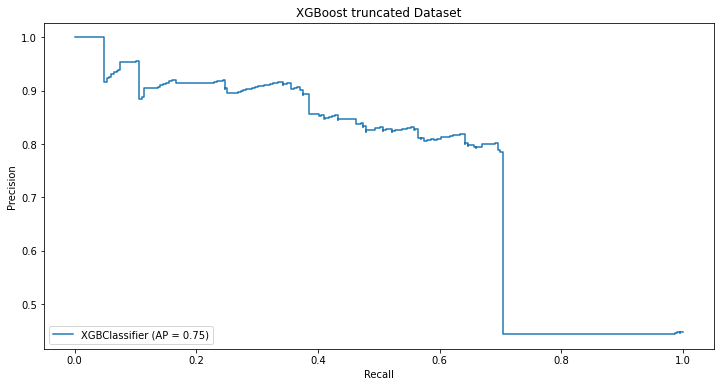

In [328]:
plot_pr_cuves([xgb_clf], np.array(x_test), y_test, 'XGBoost truncated Dataset')

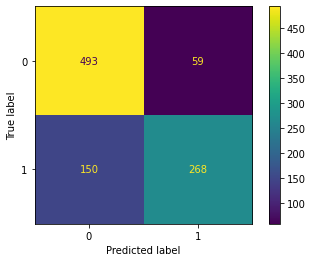

In [329]:
plot_confusion_matrix(xgb_clf, np.array(x_test), y_test)

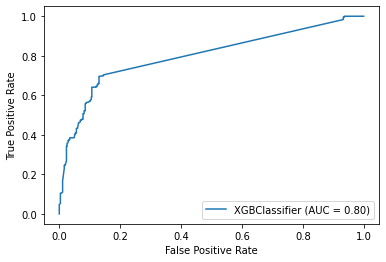

In [330]:
plot_roc_curve(xgb_clf, np.array(x_test), y_test)

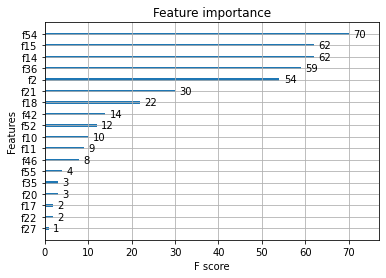

In [331]:
plot_importance(xgb_clf)

In [332]:
# Predicting on final test set 
xgb_preds = xgb_clf.predict(np.array(test.drop(['week_start_date', 'Label'], axis =1)))

In [333]:
print(classification_report(test['Label'], xgb_preds))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80     29343
           1       0.02      0.68      0.04       277

    accuracy                           0.67     29620
   macro avg       0.51      0.67      0.42     29620
weighted avg       0.99      0.67      0.79     29620



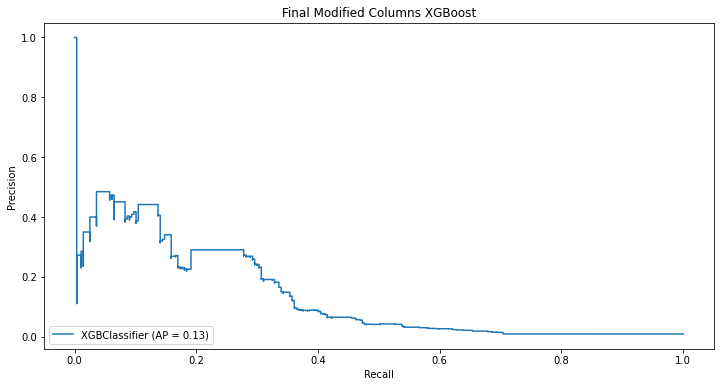

In [334]:
plot_pr_cuves( [xgb_clf], np.array(test.drop(['week_start_date', 'Label'], axis =1)), test['Label'], 'Final Modified Columns XGBoost')

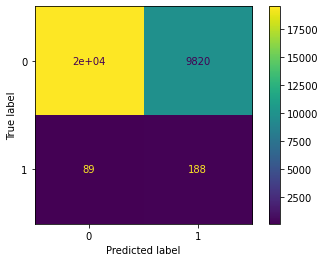

In [335]:
plot_confusion_matrix(xgb_clf, np.array(test.drop(['week_start_date', 'Label'], axis =1)), test['Label'])

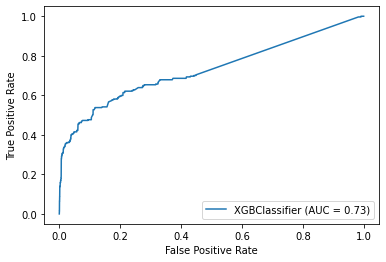

In [336]:
plot_roc_curve(xgb_clf, np.array(test.drop(['week_start_date', 'Label'], axis =1)), test['Label'])